In [1]:
import torch
from torch import optim
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from einops import repeat

import pandas as pd
import itertools

from utils.data import *
from common.res_infor import *
from utils.dataset import *
from diffusion_model.sequence_diffusion_model import *
from benchmark.sequence_metric import sequence_recovery_rate

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH = 100
LEARNING_RATE = 1e-3
fixed_length = 16

In [3]:
# Load data
train_data = pd.read_csv('./data/train_data.csv')
test_data = pd.read_csv('./data/test_data.csv')

In [4]:
# subsample data
train_data = subsample_protein_data(train_data, fixed_length=fixed_length)
test_data = subsample_protein_data(test_data, fixed_length=fixed_length)

In [5]:
# Data loader
train_dataset = ProteinDataset(train_data)
test_dataset = ProteinDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)

# Print some Sequence data

In [6]:
# print some Sequence data
def tensor_to_string(tensor, label_res_dict):
    sequences = []
    for i in range(tensor.size(0)):
        sequence = ""
        for residue in tensor[i]:
            if residue.item() == 0:
                sequence += '-'  # Skip this residue
            elif residue.item() == 21:
                sequence += "*"
            else:
                sequence += label_res_dict[residue.item()]
        sequences.append(sequence)
    return sequences
    
for batch_idx, (pdb_id, res, atom_coords, mask) in enumerate(train_loader):
    sequences = tensor_to_string(res, label_res_dict)
    print(pdb_id[:5])
    print(sequences[:5])
    break

("('4wve', 'A')", "('2i0o', 'A')", "('3qyf', 'A')", "('2pmi', 'A')", "('5a15', 'A')")
['PTKYGPVKGDSIVEKE', 'SLGAYLSEPLTTKDSS', 'FQGEVHVCSVGTSLLK', 'ATVYKGLNKTTGVYVA', 'FPEVVELNVGGQVYFT']


# Visualization of the forward process

In [7]:
# Visualization of the forward process
diffusion = SequenceDiffusion(res_num=fixed_length)

pdb_id, res, _, _= next(iter(train_loader))
pdb_1 = pdb_id[0]
x_t = res[0].reshape(1, -1)
print(pdb_1)

for t in range(0, 101, 10):
    t = torch.tensor([t])
    x_t, _, _= diffusion.seq_q_sample(x_t, t)
    sequences = tensor_to_string(x_t, label_res_dict)
    print(f"t = {t.item()}:", sequences)

('1wcw', 'A')
t = 0: ['AVRVAYAGLRRKEAFK']
t = 10: ['AVRV*YAGLRRKE*FK']
t = 20: ['AVRV**AGLR**E*FK']
t = 30: ['AV*V**AGLR**E*FK']
t = 40: ['AV*V**AGLR*****K']
t = 50: ['AV****AG*R*****K']
t = 60: ['A*****A**R******']
t = 70: ['****************']
t = 80: ['****************']
t = 90: ['****************']
t = 100: ['****************']


# Model training

In [8]:
diffusion = SequenceDiffusion(res_num=fixed_length, device=DEVICE)
model = SequenceModel().to(DEVICE)
optimizer = optim.Adam(params=model.parameters(), lr = 1e-3)

In [ ]:
def loss_function(x_pred, x_true, mask, fixed_length):
    """
    The objective function from https://arxiv.org/pdf/2107.03006.pdf (Eq. 14)
    """
    T = 100
    cross_entropy_loss = F.cross_entropy(x_pred.transpose(1,2), x_true.to(torch.int64), ignore_index=-1, reduction='none')
    cross_entropy_loss = torch.sum(cross_entropy_loss, dim=1)
    
    Comb = 

In [10]:
loss_history = []
for epoch in range(EPOCH):    
    model.train()
    train_loss = 0
    for batch_idx, (pdb, res_label, atom_coords, mask) in enumerate(tqdm(train_loader, leave=False)):
        # Data preparation
        x_0 = res_label.to(DEVICE)
        x_0 = x_0.to(torch.float32)
    
        n_coords = atom_coords[:, :, 0]
        ca_coords = atom_coords[:, :, 1]
        c_coords = atom_coords[:, :, 2]

        pair_repr = torch.cdist(ca_coords, ca_coords, p=2)
        rotations, translations = rigidFrom3Points(n_coords, ca_coords, c_coords)
        
        # Foward Diffusion
        batch_size = atom_coords.shape[0]
        t, pt = diffusion.sample_timesteps(batch_size = batch_size, device=DEVICE)

        x_t, x_0_ignore, mask = diffusion.seq_q_sample(x_0, t)
        print(t)
        
        break
        # Backward Diffusion
        x_0_hat_logits = model(x_t, pair_repr.to(DEVICE, torch.float32), rotations.to(DEVICE,torch.float32), translations.to(DEVICE, torch.float32))
        
        
        
        # Custom loss function
        cross_entropy_loss = F.cross_entropy(x_0_hat_logits.transpose(1, 2), 
                                             x_0_ignore.to(torch.int64), 
                                             ignore_index = -1, reduction='none')
        
        cross_entropy_loss = torch.sum(cross_entropy_loss, dim=1)

        vb_loss = cross_entropy_loss / t
        vb_loss = vb_loss / pt
        vb_loss = vb_loss / (math.log(2) * x_0.shape[1:].numel())

        loss = vb_loss.mean()

        optimizer.zero_grad()
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    avg_loss = train_loss / len(train_loader.dataset)
    loss_history.append(avg_loss)
    print('====> Epoch: {} Average loss: {:.10f}'.format(epoch, avg_loss))

tensor([ 5, 87, 41, 20, 24, 61,  9, 60, 45, 82, 27, 95,  4,  2, 83, 18, 54, 49,
        80, 68,  2, 29, 87, 43, 21, 74, 17, 27, 54, 29,  1,  1, 76, 74, 87,  2,
        23, 41,  1, 66, 92, 40, 84,  1, 63, 11, 34, 35, 99, 90, 56, 12, 13, 53,
        50, 60, 91, 57, 17, 47, 69, 55, 76, 96, 50, 54, 50, 73, 42, 76, 10, 38,
         2,  9,  5, 75, 42, 92, 18, 80, 99, 35, 26, 59, 82, 20, 20, 71, 35, 74,
        41, 43, 60, 56, 88, 65, 11, 97, 12, 24, 82,  6, 66, 58, 25, 41, 84, 78,
        11, 42, 46, 83, 12, 77, 20, 32, 71, 66,  1, 96, 54, 80, 42,  5, 21, 30,
        98,  2], device='cuda:0')
====> Epoch: 0 Average loss: 0.0000000000


tensor([70, 47,  9, 28, 99, 67, 25, 28, 64,  2, 79, 51, 36, 30, 76, 25, 86, 21,
        37, 39, 29, 11, 99, 12, 91,  1, 20, 57, 52, 21, 92, 32, 51, 65, 82, 99,
        67, 71,  2, 96, 85, 13, 22,  5, 97, 40, 68, 38, 12, 39, 86, 19, 19, 30,
        22, 91, 36, 91, 93, 38, 64, 14, 76, 89, 96, 14, 63, 20, 23, 48, 86, 52,
        29, 33, 51, 29, 45, 53, 86, 94, 23, 98, 56, 98, 29, 94, 88, 57, 99,  4,
        93, 33, 30, 38, 92, 40, 76, 40, 63, 25, 21, 40, 11, 77, 74, 88, 50, 49,
        72, 71, 49, 28, 89, 41, 92, 15, 39, 30, 66,  5, 25, 21, 70, 87, 72,  6,
        23, 27], device='cuda:0')
====> Epoch: 1 Average loss: 0.0000000000


tensor([66, 15, 47, 97, 22, 86, 17, 12, 92, 54, 65, 77, 54, 27, 29, 44, 61, 75,
        73, 52, 90, 90, 70, 80, 11, 23, 52, 44, 23, 16, 83, 41, 14, 10, 56, 51,
        71, 53, 44, 53,  2, 83, 47, 74, 15, 82, 84, 53,  8, 65, 80, 80, 63, 23,
        98, 38, 87, 94, 62, 52, 21, 66, 17, 50, 26, 52,  3, 91,  3, 58, 24, 35,
        27, 65, 12, 77, 84, 89, 59, 20, 98, 47, 13, 40, 41, 21,  7, 69,  6, 40,
         4, 16, 78, 54, 90, 79, 57, 41, 37, 71, 51, 19, 61, 13, 99, 88,  7, 30,
        37, 11, 18, 82, 11, 67, 48, 72, 89,  5, 73, 80, 12, 16, 95, 57, 74, 37,
        24, 94], device='cuda:0')
====> Epoch: 2 Average loss: 0.0000000000


tensor([37, 57, 29, 27, 27, 38, 89, 68, 56, 26, 46, 30, 14, 48, 94,  2, 37, 62,
        42, 71, 64,  4,  6, 61, 30, 84, 55, 66, 12, 40, 59, 50, 13, 20, 14, 48,
        82, 96, 38, 31, 91, 10, 27, 92, 12, 91, 16, 44, 70, 68, 88, 47, 37, 92,
        10, 75, 84, 94, 90, 34, 15,  2, 62, 60, 81, 30,  3, 63, 15, 20, 20, 24,
        38, 74, 80, 98, 84, 83, 99, 30, 65, 99, 30, 75, 56, 48, 58, 56, 21, 46,
        81, 11, 17,  2, 33, 29, 60, 40, 23, 58, 94, 97, 14, 71,  8, 48, 48, 89,
        10, 27, 73, 19, 90, 33, 85, 99, 69, 94, 38, 79, 84,  9, 24, 63, 82, 45,
        98, 34], device='cuda:0')
====> Epoch: 3 Average loss: 0.0000000000


tensor([59, 29, 74, 94, 23, 63, 54, 88, 43, 93, 78,  5, 84,  8, 80, 63, 63, 65,
        20, 82, 81, 71, 76, 70, 95, 64,  5, 77, 81, 75, 38, 51, 55, 92, 14, 28,
        66, 25, 32, 90, 32, 40, 59, 52, 47, 95, 43, 99, 49,  3, 36, 34, 10, 20,
         3, 38, 61, 22, 69, 22, 38,  9, 68, 96, 51, 53, 83, 97, 22, 57, 95, 49,
        86, 45, 89, 67, 67, 53, 21, 63, 20, 14, 35, 72, 75, 75, 58, 86,  8, 56,
        98,  5, 11,  1, 36, 29, 43, 65, 88, 32, 27, 79, 56, 36, 36, 90, 32, 85,
        59, 78, 17, 40, 53, 78, 32, 74, 55, 88, 27, 12, 66, 53, 76, 95, 87, 31,
        49, 66], device='cuda:0')
====> Epoch: 4 Average loss: 0.0000000000


tensor([26, 30, 67, 56, 85, 39, 82, 79, 71, 18, 47, 53, 95, 73, 67, 19, 36, 75,
        28, 24, 71, 28, 64, 45, 94, 84, 17, 27, 50, 21, 85, 70, 35, 82, 90, 34,
        44, 72, 12, 46, 10, 97, 82, 37, 18,  2, 13, 79, 25, 74, 63, 71, 73,  4,
        17,  1, 64, 32, 89, 18, 89, 19, 72, 55,  4, 49, 76, 85, 23, 92, 90, 41,
        40, 10, 50, 78, 36, 18, 14, 26, 57, 53, 85, 72, 58, 13, 59, 42, 52, 19,
        48,  1, 53, 29, 33, 87, 57, 70, 64, 13, 98, 35,  4, 69, 68, 67, 62, 34,
        36, 73, 67, 62, 13, 68, 10, 17, 97, 33, 64, 42, 23, 45, 60, 48, 32, 34,
        45, 26], device='cuda:0')
====> Epoch: 5 Average loss: 0.0000000000


tensor([52, 60, 11, 77, 56, 42, 42, 62, 70, 60, 92, 61, 11, 74, 74, 75, 89,  1,
        28, 98, 67, 65, 63, 13, 79, 62, 92, 87, 35, 74, 71, 63, 14, 37, 29, 66,
        51, 24, 41, 45, 73,  3,  1, 68, 21, 33, 13, 10, 49, 59, 87, 91, 69, 65,
        96,  6, 88, 27, 17, 45, 34, 56, 20, 73, 92, 95, 94, 21, 28, 90, 75, 69,
        91, 81, 47, 13, 20, 50, 91, 22, 23, 33, 59, 12, 78,  9, 11, 81, 54, 15,
        41, 24, 34, 71, 14, 53,  7, 62, 71, 96, 14, 30, 26, 29, 37, 51,  3, 81,
        31, 81, 49, 94, 88, 30, 72, 15, 72, 47, 36, 39, 26, 29, 47, 65, 26,  6,
        50, 59], device='cuda:0')
====> Epoch: 6 Average loss: 0.0000000000


tensor([64, 13, 84, 15, 57, 63,  3, 93, 19, 39,  5, 63, 99, 42, 81, 87,  4, 86,
        76, 90, 60, 66, 34, 64, 96, 26, 44, 43, 90, 55, 28, 61, 39, 72, 65, 34,
        28, 48, 61,  3, 35,  9, 73, 60, 85, 68, 25, 19,  9, 42, 80,  1, 50, 35,
        97, 66, 10, 54, 81, 11,  3, 20, 92, 61, 49,  8, 34,  8, 30,  2, 79, 83,
        43, 52, 62, 63, 15,  1, 49, 79, 70, 91, 47,  8, 74, 12, 28, 35, 40, 54,
        49, 41, 24, 55, 74, 81,  3, 53, 18, 53, 36, 40,  4, 11, 59, 11, 65, 84,
        53, 89, 76, 70, 93, 74, 81, 95, 38,  2, 67, 56, 40, 78, 17, 95, 43,  6,
        25, 37], device='cuda:0')
====> Epoch: 7 Average loss: 0.0000000000


tensor([19, 47, 97, 21, 57, 67,  1, 36, 10,  9, 72, 43, 30, 20, 73, 36, 82, 93,
        33, 56, 55, 63, 13, 78, 47, 10, 74, 43, 13, 89, 20, 51, 61, 62, 20, 13,
        64, 15, 82, 90, 99, 87, 79, 42, 55, 48, 57, 73, 15, 82, 95, 26, 55, 59,
        93, 38, 32, 79, 81, 69, 33, 96, 27, 53, 18, 76, 60, 23, 31, 94, 36, 68,
        18,  6, 76, 74, 16, 19, 73, 84, 86, 37, 43, 21, 85, 99, 70,  5, 41, 37,
        31, 89, 92, 15, 64, 61, 72, 55, 81,  6, 19, 79,  9, 73, 36, 58, 93, 13,
        49, 28, 58, 99, 76, 94, 39, 68,  8, 80, 45, 92, 37, 14, 69, 34, 43, 53,
        89, 54], device='cuda:0')
====> Epoch: 8 Average loss: 0.0000000000


tensor([93, 60, 44, 49, 29, 88, 15, 24, 78, 71,  6, 57, 70, 17, 27, 85, 66, 22,
        20, 56, 35, 45, 35, 55, 79, 96, 25,  9, 11, 48, 30, 27, 38, 76, 14, 82,
        36,  4, 57, 70, 14, 36,  3, 19, 72, 68, 26, 52, 27, 48, 23,  2, 80, 31,
        92, 72, 70, 89, 96, 55, 66, 27, 31, 34, 24, 13, 58, 18, 57, 25, 60,  1,
        45, 88, 35, 76, 66, 57, 38, 84, 97, 38, 13, 61, 88, 33, 65,  7, 89, 39,
        46, 29, 30, 99, 88, 52, 57, 56, 36, 98, 41, 86, 78, 27, 22, 13, 12, 72,
        49,  5, 90, 75, 89,  9, 54, 75, 84, 32, 88, 56, 27, 22, 39, 30, 98, 10,
        66, 82], device='cuda:0')
====> Epoch: 9 Average loss: 0.0000000000


tensor([53, 34, 33, 82, 64, 57, 55, 34, 30, 34, 23, 73, 69, 97, 86, 74, 26, 69,
        28, 49, 76, 44, 60, 47, 67,  1, 29, 32, 29, 45, 57, 16, 79, 25, 43, 59,
        74, 95, 80, 27, 53, 76, 42, 38, 96, 37, 95, 31, 60, 30, 25, 33, 41, 63,
        36, 35, 98, 29, 24, 29, 44, 61, 42, 39,  7, 72, 56, 99, 68, 60, 68, 44,
         7, 88, 14, 89, 35, 59, 53, 52, 22, 64, 73, 29, 56, 24, 11, 75, 96, 25,
        70, 21, 45, 55, 42, 37, 88, 14, 80,  1, 63, 99, 70, 48, 17, 46, 62, 92,
        27, 61, 33, 81, 64, 77, 50, 45, 97, 87, 47, 61, 69, 26, 42, 10, 92, 76,
        71, 59], device='cuda:0')
====> Epoch: 10 Average loss: 0.0000000000


tensor([36, 88, 75, 79, 71,  4, 49, 98, 90, 33, 41, 66, 45, 71, 45, 68, 65, 17,
        33, 33, 80, 11, 31, 10,  8,  4, 25, 42, 62, 13, 94, 52, 66, 38, 60, 73,
         7, 15, 56, 29, 91, 46, 36, 28, 47, 93, 15, 99, 83, 49, 49, 92, 24, 44,
        41, 78, 13, 68, 56, 83, 40, 76, 22,  2, 66, 10, 49, 68, 93, 44, 87, 64,
        56, 14,  6, 97, 91, 82, 82, 10, 90, 27, 44, 58,  2, 13, 12, 12, 35, 59,
        49, 88, 79,  9, 48, 41, 66, 31,  8, 42, 79, 31, 77, 35, 66, 79, 49, 50,
        55,  4, 93, 78, 77, 39, 59, 36, 83, 76, 18, 25, 23, 35, 72, 99, 99,  1,
        70, 82], device='cuda:0')


====> Epoch: 11 Average loss: 0.0000000000


tensor([27,  2, 62, 64, 59, 61, 62, 73, 85, 73, 71, 65, 43, 42, 30, 50, 64, 52,
        10,  7,  6, 63, 75, 41, 61, 99, 28, 48,  7, 28,  9, 68, 57, 80, 89, 23,
        40, 92, 24,  9, 55, 39, 32, 14, 68, 80, 61, 91, 55, 17,  5, 18, 16, 40,
        17, 61, 76, 82, 67, 65, 84, 97, 83, 58, 84, 68,  9, 77, 59, 24, 98, 49,
        20, 83, 93, 50, 82, 68,  6, 85,  9,  1, 49, 82, 51,  4, 49, 23, 48, 88,
        82,  1, 16, 88, 49,  9,  6, 57, 40, 25, 72, 53, 26, 96, 84,  7, 31, 35,
        51, 45, 84, 32, 52, 47, 34, 24, 78, 51, 58, 27, 18, 92, 80, 31, 26, 43,
        25, 91], device='cuda:0')
====> Epoch: 12 Average loss: 0.0000000000


tensor([42, 61, 36, 79, 53, 36, 52, 95, 13, 39, 48, 75, 74, 27, 79, 29, 80, 60,
        77, 38, 25, 33, 16, 26, 21, 99, 93, 43, 51, 41,  8, 38, 99, 43, 93,  7,
        41, 22, 47,  9, 57, 85, 21, 13, 38, 98, 29, 33, 37, 41, 74, 14, 73, 48,
        16, 92, 41, 53, 56, 70, 99, 56, 79, 71, 57, 48, 53,  4, 52, 90, 12, 64,
        13, 63,  9,  7, 82, 52, 89, 51, 13, 99, 23, 96, 99, 51,  3, 42, 51, 42,
        36, 43, 68, 74, 36, 81, 36, 77, 26, 91, 70, 52, 40, 31, 52, 94,  3, 39,
        62, 33,  8, 23, 37, 52,  3, 25, 52, 50, 71,  9, 33, 93, 85, 11, 34, 84,
        15, 97], device='cuda:0')


====> Epoch: 13 Average loss: 0.0000000000


tensor([41, 22, 86, 68,  3,  4, 58, 98, 60, 35, 62, 18, 75, 17, 65, 37, 53,  2,
         4, 69, 59, 66, 50, 20, 53, 51, 78,  4, 99, 50, 91, 18, 11, 99, 88, 73,
        64, 53, 93, 36, 20, 97, 20, 38, 98,  9,  1, 14, 57, 64, 21, 34, 86, 85,
        28, 84, 10, 63, 63, 13,  3, 79, 47, 18, 15, 39, 90, 99, 26, 10, 35, 39,
        92, 11, 52, 67, 54, 91, 39, 33,  6, 62, 22, 76, 69, 39, 73, 47, 21, 42,
         1, 56, 61, 98, 59, 23, 94, 47, 97, 40, 75, 29, 60, 44, 67, 26, 92, 86,
        95, 64,  9,  2, 53, 28, 68, 62, 63, 95, 90, 73, 12, 29, 30, 52, 94, 86,
         7, 24], device='cuda:0')
====> Epoch: 14 Average loss: 0.0000000000


tensor([19, 70, 63, 78, 77, 36, 42, 74, 99, 69, 12, 26, 50, 23, 65, 30, 98, 50,
        71, 81, 87, 18, 98, 13, 25, 36, 77, 21, 77, 57, 66, 44, 94, 22, 21,  5,
        55, 28, 47, 11, 15, 15, 13,  1, 93, 72, 62, 73, 82, 65, 65, 38, 98, 52,
        87, 83,  8,  2,  1, 10,  7, 93, 28, 97, 62, 45, 74, 64, 48, 56, 20,  5,
        75, 21, 65, 60, 48, 97,  1,  9,  2, 55, 94, 29, 61, 74,  7,  5, 88, 85,
        24, 23, 41, 63, 86, 79, 88, 29,  3, 45, 81, 80, 64, 11, 73, 65, 46, 38,
        51, 62, 81, 60,  2, 25, 33, 57,  7,  2, 65, 46,  6, 19,  1, 88, 76, 11,
        86, 82], device='cuda:0')
====> Epoch: 15 Average loss: 0.0000000000


tensor([ 4, 51, 93, 85, 93, 10, 43,  9, 93, 40, 29, 27, 63, 74, 11, 87, 89, 21,
        14, 86, 57, 57, 89, 53, 11, 56, 96, 12, 14, 40, 81, 23, 58, 89, 19, 72,
        69, 21, 98, 89, 21, 84, 62, 25, 60, 70, 42, 48, 48, 65, 31,  5, 63, 43,
        91, 73, 65,  2, 11, 84, 57, 44, 48, 48, 57, 36, 80, 87, 60, 95,  9, 14,
        20, 96, 79, 96, 33, 99, 67,  2, 34, 52, 29,  8, 73, 50, 92, 80, 93, 51,
        88, 45, 89, 37, 81, 42, 90, 91, 75, 17,  6, 96, 84, 76, 57, 74, 99, 57,
        43, 66, 41, 57, 99, 72, 25, 28, 92, 59, 49,  9, 99, 37, 89, 32, 54, 64,
        43, 91], device='cuda:0')
====> Epoch: 16 Average loss: 0.0000000000


tensor([77, 77, 75, 30, 26, 58, 82, 89,  9, 49, 77, 42, 46, 35, 83, 20, 18, 83,
        74,  2, 25, 54, 48, 99, 18, 69, 58, 86, 67, 49, 95, 62, 71, 79,  1, 60,
        99, 41, 99, 28, 63, 99, 79, 31, 80, 93, 16, 56, 71, 30, 20, 95,  7, 35,
        42, 79, 33, 58, 65, 90, 58, 40, 59, 98, 34, 54, 59, 43,  8, 92, 68, 37,
        15, 57, 89, 60, 59, 96, 78, 92, 81, 30, 87, 39, 31, 47, 33, 15, 49, 46,
        43, 80, 87, 12, 77, 14, 62, 79, 38, 15, 77, 20, 68, 17, 55, 26, 18, 36,
        25, 90, 72,  8, 30, 60, 36, 89, 92, 50, 70, 77, 65, 32, 78, 53, 57, 30,
        66, 44], device='cuda:0')


====> Epoch: 17 Average loss: 0.0000000000


tensor([31,  1, 66, 79, 13, 48, 25, 96, 72, 56, 22, 81, 21, 25, 30, 42, 41, 20,
        61, 65, 78, 33, 93,  8, 44, 68, 30, 54, 60, 22, 16, 28, 86, 95, 81, 25,
        81, 13, 62, 58, 22, 71, 55, 37, 23, 76, 12, 64, 63, 36, 81, 61, 93, 86,
        70, 98, 65, 81, 69, 20, 36, 56, 89, 96, 83, 53, 14, 48, 13, 35, 24, 43,
        12, 92, 11, 34, 34,  7, 40, 88, 69, 16, 82, 70, 79,  8,  3, 21, 73, 71,
        73, 10,  3, 49, 24, 65, 36, 73, 44, 41, 15, 86, 42, 48, 75, 89, 40, 31,
        30,  6,  3, 77, 76,  6, 98, 12, 70, 29, 29, 75, 20, 28, 72, 45, 18, 11,
        16, 77], device='cuda:0')


====> Epoch: 18 Average loss: 0.0000000000


tensor([17, 17, 35, 51, 71, 11, 60, 14, 75, 56, 40, 75, 46, 37,  8, 22, 37, 19,
        98, 19,  9, 98,  1, 13, 18, 88, 25, 91, 64, 54, 57, 44, 18, 75, 98,  5,
        11, 90, 10, 63, 43, 20, 59, 31, 30, 89, 98, 96, 85, 32, 89, 18, 51, 61,
        12, 55, 40, 84, 90, 30, 68, 46, 20,  9, 59, 84, 48,  9, 99, 70, 42, 17,
        34, 77, 90, 70, 24, 97, 53, 66, 62, 33, 53, 12, 17, 36, 13, 69, 95, 33,
         1, 76, 22, 27, 17, 53, 66, 98, 16, 39, 88, 87, 93, 97, 67, 19, 47, 57,
        27, 28, 50, 44,  6, 95, 34, 94, 68, 56, 53, 49,  1, 27, 77, 81, 51, 49,
         5, 84], device='cuda:0')


====> Epoch: 19 Average loss: 0.0000000000


tensor([ 9, 57, 66,  1, 91, 83, 38, 20, 20, 72, 39, 37,  9, 51, 64, 99, 60, 74,
        49, 30,  7, 61, 92, 48, 47, 44, 29, 79, 53, 79, 81, 79, 35, 36, 75, 32,
        12, 79, 59, 85, 47, 53, 95,  4, 48, 21, 56, 90, 47, 91, 44, 58, 15, 89,
        82, 97, 49, 43, 96, 11,  9, 13, 77, 88, 77,  6, 53, 89, 93, 98, 34,  9,
        85, 38,  2, 49,  7, 93, 33, 56, 89, 46, 69, 87, 22, 30, 98, 58, 82, 76,
        22, 92, 10, 29, 72, 58, 72, 43, 94, 37, 97, 73, 20, 86, 34, 35, 48, 14,
        23, 47, 18, 37, 27, 18, 22, 19, 46, 25,  7, 17, 61, 81, 68,  3, 36, 33,
        61, 69], device='cuda:0')


====> Epoch: 20 Average loss: 0.0000000000


tensor([94, 63, 50, 89, 82, 31, 20, 46, 13, 13, 39, 32, 65, 58, 11, 32, 36, 56,
        51, 15, 55, 16, 39, 29,  2, 38, 41, 40, 32, 86, 79, 29, 70, 65, 81, 85,
        95, 48, 81, 71, 84,  9,  5,  8, 63, 39, 16,  8, 51, 65, 79, 62, 34, 99,
        69, 52,  4, 52, 51, 88, 82, 63,  7, 84,  9, 20, 37, 50,  4,  7, 64, 87,
        18, 11, 60, 89, 97, 10, 93, 74, 98, 84, 96, 88, 61, 26, 61, 49, 71,  1,
        26, 38,  3, 31, 54, 68, 37, 80, 16, 91, 76,  6, 56, 86, 10, 40, 29, 46,
        91, 62, 50, 56, 58, 71, 46, 42, 20, 84, 50, 22, 24, 47, 19, 85, 42, 84,
        59, 44], device='cuda:0')


====> Epoch: 21 Average loss: 0.0000000000


tensor([ 1, 15, 53, 34,  8, 64, 10, 64, 70, 18, 98, 64, 57, 97, 89, 91, 76, 91,
        89, 41, 83, 87, 92, 41, 31,  6, 33, 62, 36, 73, 45, 57, 47,  9, 31, 14,
        49, 53, 23, 86, 99, 40, 79, 17,  9, 25, 14, 98, 66, 53, 95, 50, 73, 42,
        67,  1, 49, 19, 65, 56, 10, 88, 26, 11,  2, 16, 19, 60, 86, 61, 44, 99,
        97, 50, 57, 34, 45,  3, 69, 99,  9, 12, 31, 82, 76, 43, 91, 17, 72, 67,
         8,  9, 12, 80, 65, 28, 33, 78, 58, 81, 22, 51, 76, 79,  5, 93, 55, 53,
        80, 70, 31, 33, 88,  3,  3,  2, 85, 67, 43, 89, 75, 17, 88, 45, 99, 63,
        99, 30], device='cuda:0')


====> Epoch: 22 Average loss: 0.0000000000


tensor([98, 62,  2, 67, 93, 26, 16, 61, 18, 87, 35, 71, 97, 50, 34, 17, 63, 31,
        77, 11, 93, 75, 35, 45, 88,  5, 88, 46, 20, 94, 17, 15, 48,  8, 48,  3,
        23, 97, 84, 66, 79, 47, 92, 40, 37, 14, 25, 24, 47,  8, 99, 69, 21,  3,
        96, 28, 17, 70, 46, 19, 15, 38, 65, 66, 73, 61, 76, 65, 67, 90, 81, 34,
        99,  2, 17, 58, 70, 64, 12, 36,  3, 47, 34, 90, 17, 17, 38, 36, 37, 27,
        39, 51,  4, 34, 69, 31, 66,  8, 44, 30, 77, 50, 31, 29, 85, 41,  3, 88,
        33, 34, 55, 36, 92, 83, 41, 12, 55,  1, 64, 26, 85, 31, 81, 23, 33, 90,
        68, 87], device='cuda:0')


====> Epoch: 23 Average loss: 0.0000000000


tensor([89, 29, 14, 42, 56, 48, 53,  2, 81, 42, 71, 54, 52, 45, 13, 67, 88, 98,
         1, 80, 94, 31, 25, 10, 29, 89, 88, 17, 31, 13, 15, 42, 34, 23, 96,  7,
        18, 74, 26, 96, 25, 35, 17, 72, 30, 37,  6, 24, 73, 89, 89, 53, 87, 72,
        61, 72, 48, 54, 67, 68, 76, 87, 56, 19, 92, 59, 92,  1, 82, 28, 22, 84,
        12, 34,  1, 23, 42, 85, 56, 28, 20, 62, 91, 11, 43, 73, 87,  7, 83, 38,
        34, 73, 40, 34, 36, 16,  2, 10, 44, 55, 86, 65, 77, 85, 99, 10, 12, 30,
        54, 49, 90, 74, 48, 16, 65,  6,  4, 39, 27, 22, 41,  1, 58, 64, 29, 92,
        25, 89], device='cuda:0')


====> Epoch: 24 Average loss: 0.0000000000


tensor([62, 95, 68, 59, 53, 87, 53, 22, 31, 12,  1, 43, 52, 62, 99, 54, 15, 35,
        47, 73, 38,  6,  3, 44, 38, 36, 71, 50, 11,  6, 84, 26, 96, 17, 79, 99,
        22, 55, 10, 57, 16, 94,  6, 64, 68, 42,  1, 88, 77, 79, 85, 59, 61, 85,
        58, 42, 62, 55, 79, 86, 69, 86, 71, 24, 16, 44, 30, 44,  1, 44, 22, 52,
        73, 28, 25, 78, 34, 88, 71, 88, 46, 51, 38, 28, 51, 12, 34, 52, 58, 85,
        71, 83, 39, 86, 91, 87, 70, 74, 52, 94,  5,  1, 37, 45, 52, 60, 74, 16,
        93, 54, 81, 97, 79, 27, 28, 87, 68, 26, 82, 79, 95, 80, 30,  5, 22, 10,
        51, 56], device='cuda:0')


====> Epoch: 25 Average loss: 0.0000000000


tensor([27, 49, 50, 55, 50, 93, 76,  6, 36, 43, 88, 45, 40,  2, 44, 37, 81, 37,
        59, 15, 22, 10, 53, 99, 39, 73, 26, 46, 66, 85, 16, 92, 41, 76,  2, 47,
        68, 80,  9, 73, 52, 23, 44, 91, 32, 14, 31, 64, 79, 28, 33, 21, 82,  2,
        93, 65, 33, 27, 35, 63, 73, 83, 36, 40, 21, 36, 14, 56, 10, 36, 27, 75,
         1, 62, 60, 19, 37, 66,  6, 80, 30, 15, 60, 36, 25, 56, 76, 45, 19, 94,
        79, 17, 88, 27, 52, 52, 32, 82, 24, 50, 63,  3, 42, 40, 50, 13, 87,  2,
        88,  5, 48, 42, 43, 72, 33, 24, 37, 10, 96, 43, 44, 70,  3, 91, 94, 50,
        85, 85], device='cuda:0')


====> Epoch: 26 Average loss: 0.0000000000


tensor([97, 42, 39, 34, 76, 25, 37, 24,  8, 39, 63, 97, 64, 50, 59, 28, 72, 48,
        59,  2, 75, 90, 91, 30, 68, 36, 67,  3, 33, 34, 27, 25, 76, 62, 95, 61,
        32, 11, 78, 69, 54, 40, 51, 23, 99, 70, 91, 41, 27, 48, 81, 50, 39, 22,
        83, 54, 53,  9, 42, 35, 76, 98,  7, 76,  7, 68, 63, 35, 59,  5, 60, 26,
        29, 92, 44, 22, 67, 82, 12, 30, 61, 58, 88, 36,  8, 92, 49, 65, 74, 55,
        28, 98, 90, 20, 65,  8, 20, 68, 63,  3, 61, 50, 41,  1, 77, 61,  4,  6,
         4, 54, 14, 16, 75,  9, 83, 27, 83, 89, 43, 10, 36, 27, 83, 85, 32, 61,
        48, 81], device='cuda:0')


====> Epoch: 27 Average loss: 0.0000000000


tensor([ 8, 64, 66,  8, 91, 90, 12, 25, 29, 44, 86, 48, 97, 72, 27, 46, 77, 77,
        29, 75, 44, 28, 29, 67, 55,  7, 93,  5, 27, 20, 61, 30, 23, 65, 69, 64,
        17, 41, 68, 78, 69, 86, 89, 52, 23,  5, 14, 38, 50, 11, 31, 85, 98, 88,
        81, 78, 49, 85, 73,  9, 47, 10, 20, 14, 49, 62, 70, 58, 39, 50, 72, 77,
        80, 60, 96, 29, 29,  2, 61, 60, 33, 16, 10, 41, 27, 44, 66, 84, 24, 70,
        10, 35, 95, 23, 44,  6,  7, 60, 42, 94, 15, 39, 18, 32,  2, 23, 50, 21,
        63, 26, 58, 32, 25, 88,  4, 47, 63, 93, 90, 83, 15, 53, 14, 74, 11, 53,
        45, 20], device='cuda:0')
====> Epoch: 28 Average loss: 0.0000000000


  0%|          | 0/418 [00:00<?, ?it/s]

tensor([14, 32, 60, 36,  5, 76, 18, 57, 26, 84, 29, 75, 44, 57, 86, 77, 65, 45,
        59, 95, 60, 46,  8, 38, 66, 45, 90, 75, 13, 14, 41, 69, 39, 27,  5, 70,
        44, 75, 76, 23, 63, 41, 16, 21, 54, 40, 55, 32,  5, 51, 55, 91, 80,  5,
        11, 69, 66, 64, 73,  4, 37, 33, 13, 86,  1, 98, 89, 45, 26, 12, 18, 32,
        69,  7, 31, 27, 53, 88, 68, 87, 54, 84, 10, 92, 44, 44, 75, 68, 64, 24,
        30, 71, 17, 65, 41, 67, 96,  9, 19, 24, 26, 56, 30, 53, 63, 86,  2, 99,
        69, 10, 57, 85, 21, 71,  4, 57, 45, 48, 27, 26, 21, 25, 10, 84, 80, 53,
         6, 35], device='cuda:0')


====> Epoch: 29 Average loss: 0.0000000000


tensor([73, 19, 58, 98, 41, 62, 85, 52, 59,  7, 40,  1, 60, 30, 30, 49,  1, 92,
        88, 63, 15, 82,  2, 54, 46, 77, 40, 11, 51, 91, 92, 56, 72,  4, 45,  7,
        14, 36, 91, 48, 69, 31, 89, 76, 56, 90, 70, 38, 58, 83, 31, 10, 88,  5,
        58, 47, 90, 27, 44, 95, 87, 22, 75,  1, 49,  6, 23, 34, 14, 36,  5, 79,
        79, 46, 67, 18, 87,  1, 16, 70, 85, 90, 18, 52, 54, 73, 62, 85,  3, 29,
        39, 35, 84, 86, 17, 70, 85, 46, 16, 68, 40, 51, 99, 15, 41, 72, 35, 56,
        59, 49, 52, 17, 68, 10, 57, 83, 10, 33, 24, 52, 32, 47, 33, 42, 67, 77,
        78, 24], device='cuda:0')


====> Epoch: 30 Average loss: 0.0000000000


tensor([29, 24, 14, 33, 92, 99, 73, 97, 36, 90, 89, 48, 13, 89, 66, 36, 77, 58,
        73, 24, 11,  2, 28, 87, 93, 79, 87, 43,  9, 37, 29, 45, 99, 71, 86, 90,
        90, 64, 70, 84, 71, 90, 49, 14, 56, 77, 10, 18, 97, 87, 28, 27, 66, 37,
        81, 98, 94, 54, 69, 65, 42, 86, 42, 69, 30, 85, 51, 57, 15,  1, 70,  3,
        67,  9, 17, 79, 57, 93, 26,  2, 37, 39, 95, 43, 43, 57,  3, 10, 94, 81,
        91,  4, 20, 46,  1, 57, 52, 99,  3, 14, 69, 34, 52,  3, 84, 19, 47, 63,
        88, 73, 21, 42, 94, 41, 17, 35, 41, 24, 38, 68, 18, 19,  9, 53, 83, 72,
        30, 91], device='cuda:0')
====> Epoch: 31 Average loss: 0.0000000000


  0%|          | 0/418 [00:00<?, ?it/s]

tensor([51, 10, 74, 20, 35, 94, 47, 46, 82, 63, 22, 98, 17, 61, 38, 25, 53, 67,
        11, 11, 40, 12, 78, 69, 16, 99, 87, 17, 99,  1, 33, 65, 97, 42, 24, 79,
        23, 81, 34, 47, 60, 55, 64, 19, 52, 62, 27, 60, 37, 26, 76, 57, 86, 64,
        58,  2, 57,  2, 82, 94, 37, 69, 67, 83, 88, 50,  8, 98, 51, 43, 66, 95,
        19, 27, 27, 73, 90, 13,  4, 17, 19, 97,  7, 68, 67, 28, 80,  8, 91, 37,
        27, 14, 52, 81, 60, 90, 84, 95, 26, 74, 88, 45, 69, 90, 91, 91, 75, 46,
         1, 71, 90, 22, 82, 93, 33, 51, 80, 91, 80, 12, 32, 63, 31, 97, 98, 40,
        58, 37], device='cuda:0')


====> Epoch: 32 Average loss: 0.0000000000


tensor([44, 89, 35, 22, 68, 45, 95, 47, 84, 78, 97, 14, 10, 42, 86, 63, 52, 27,
        91, 10, 76, 83, 34, 47, 50, 93, 62, 17, 57,  6, 33, 64, 37, 53, 61, 76,
        42, 52, 44, 49, 53, 66,  5, 71, 87, 31, 98, 30, 86, 38, 19, 38, 84, 27,
        89, 15, 16, 95, 15, 23, 32, 81, 88, 89, 49, 45, 75, 75, 99, 57, 19, 99,
        29, 76, 56, 68, 74, 84, 51, 47, 11, 32, 16, 46, 12, 85, 35, 65, 10, 70,
         7, 93, 68, 91, 88, 63, 99, 50, 24, 55, 66, 32,  2, 56, 12, 29,  3, 85,
        10, 81, 75, 98, 10, 81, 29, 20, 93, 71, 56, 43, 33, 57,  9, 15, 33, 90,
         9, 87], device='cuda:0')
====> Epoch: 33 Average loss: 0.0000000000


tensor([33,  2, 79, 71, 13, 45, 35, 80, 62, 84, 83, 78, 89, 59, 89, 97, 62, 65,
        85, 38, 72, 89, 20, 14, 12, 21, 33, 93, 78, 74,  7, 65, 46, 63, 42, 52,
        52, 44, 70, 47, 91, 10, 98, 72, 15, 16, 35, 74, 92, 52, 17, 62, 60, 44,
        32, 70, 54,  9, 90, 27, 21, 31, 45, 91, 21, 17, 65, 37, 59, 66, 68, 69,
        73, 88, 25, 62, 13, 50, 36, 41, 16,  8, 89, 85, 37, 44, 31, 50, 14, 88,
        16, 12, 63, 19, 48, 39, 47, 74, 18, 93, 59, 78, 30, 93, 16, 53, 78, 80,
        44, 30, 87, 61,  7, 35, 23, 46, 54, 72, 19, 32, 67, 77, 80,  9, 38, 99,
        16, 67], device='cuda:0')


====> Epoch: 34 Average loss: 0.0000000000


tensor([83, 72,  8, 49, 65, 91, 54, 78, 74, 23, 29,  8, 85, 78,  2, 77, 66, 99,
        36, 17, 32, 68, 41, 92,  7, 72, 23, 72, 36, 80,  7, 76, 12, 45, 49, 92,
        92, 71, 90, 30, 99, 83, 54,  9, 71, 26, 12, 43, 99, 36, 37, 28, 53, 64,
        40, 89, 28, 55, 82, 86, 43,  2, 23, 13, 35, 30, 22, 26, 56,  3, 16, 49,
        90, 49, 63, 96, 14, 12, 72, 16, 93, 70, 95, 25, 84, 51, 47, 64, 74, 84,
        36, 30, 57, 39, 31, 67, 29, 56, 97, 57, 53, 49, 43, 41, 11, 94,  9, 79,
         9, 26, 64, 88, 87, 86, 46, 62, 81, 87, 64, 17, 74, 28, 38, 13, 36, 80,
        76, 92], device='cuda:0')


====> Epoch: 35 Average loss: 0.0000000000


tensor([98, 81, 66, 53,  2, 33, 60, 81, 51, 81,  1, 63,  8, 37, 85, 48, 56, 84,
        70, 98,  8, 96,  2,  9, 78, 21, 31, 93,  9, 55, 60, 95, 22, 22, 66, 77,
        20, 20,  8, 15, 68, 69, 69, 38, 54, 79, 38, 96, 90,  6,  9, 76, 30, 99,
        45, 89, 87, 54, 20, 66, 41, 96, 36, 74, 64, 65,  5, 22, 91, 18,  9, 35,
        44,  3, 21, 64, 68, 36, 86, 46, 53, 36, 79, 62, 97, 74, 63,  2, 13, 26,
        81, 49, 44, 83, 72, 80,  7, 69, 74,  2, 95, 53, 43, 89, 83, 51, 24, 65,
        15, 11, 10, 79,  1, 98, 92, 53, 81, 88, 31, 81, 76, 94, 69, 39, 94, 18,
        12, 19], device='cuda:0')


====> Epoch: 36 Average loss: 0.0000000000


tensor([87, 29,  8, 66,  5, 76, 49, 44, 72, 38, 24, 81, 33,  4, 45, 91, 92, 65,
        11, 64, 67, 54, 96, 46, 34, 10, 15, 14, 51, 72, 98, 54, 16, 73,  8, 93,
        83, 59, 19, 55, 23, 20,  6, 48,  2, 76, 54, 17, 32,  5, 86, 77, 96, 32,
        52, 72, 87,  6, 74, 36, 14, 50, 22, 87, 93, 36, 46, 95, 11, 34,  4,  2,
        36, 36, 48, 92, 56, 51, 60, 43,  5, 40, 17, 64, 31, 36, 23, 29, 34, 39,
        46, 91, 72, 43, 42, 24, 23, 69, 22, 77, 31, 19, 99, 78, 18, 48,  6, 47,
        31, 98, 64, 52, 92, 96, 58, 44, 49,  5, 73, 65, 29, 63, 36, 70, 72, 43,
        85, 90], device='cuda:0')


====> Epoch: 37 Average loss: 0.0000000000


tensor([ 2, 13, 59, 79, 34, 58, 58, 49, 12, 66, 91,  5, 45, 83, 41, 60, 30, 19,
        60, 98, 92, 35, 30,  6, 30, 88, 69, 38, 18, 70, 17, 71, 51, 86, 53,  5,
        39, 97, 58, 83, 31, 73, 31, 68, 98, 58, 84, 20, 85, 37, 35, 95, 26, 61,
        57, 24, 98, 39,  5, 89, 28, 38, 55, 20, 51, 98, 70, 12, 33, 47,  5, 85,
        47, 75, 52, 52, 20, 61, 27,  8, 78, 57, 62, 47, 36, 64, 40, 20, 78, 40,
        32, 13,  2, 24, 48, 43,  4, 21, 31, 87, 28, 20,  1, 97, 86, 95, 38, 74,
        91, 12, 27, 83, 78, 29, 58, 41, 56, 70, 60, 76, 45, 89, 50, 62, 67, 18,
        82, 16], device='cuda:0')


====> Epoch: 38 Average loss: 0.0000000000


tensor([54, 22, 59, 47, 77, 81, 16, 60, 37, 24, 54, 48, 35, 72, 27, 35, 85, 43,
         1,  4, 67, 64, 43, 73, 66,  9, 15, 94, 49, 53, 70, 89, 55, 91, 18, 32,
        43,  8, 73, 27, 73, 81, 18, 56, 99, 70, 36,  8, 14, 35, 12, 20, 31, 80,
        12, 37, 41, 55, 81, 36, 13, 94, 91, 43, 33, 22, 96, 13, 62, 27, 76, 42,
        65, 33, 16, 64, 14, 19, 84, 89, 55, 90,  6, 76, 35, 60, 99, 91, 92, 66,
        52, 18,  7, 95, 52, 95, 63, 37, 17, 98, 86, 30, 37, 59, 41, 12, 20, 38,
        58, 20,  7,  3, 71,  6, 93, 24, 11, 20, 90, 59,  4, 88,  8, 66, 75, 33,
        39, 95], device='cuda:0')


====> Epoch: 39 Average loss: 0.0000000000


tensor([23, 75, 42, 85, 26, 22, 92, 46, 84, 89, 90, 55, 96, 59, 18, 51, 29,  6,
        90, 22, 76, 68, 40,  4, 33, 28, 44, 20, 46, 74, 47, 19, 84, 58, 94, 88,
         2, 41, 36,  6, 92, 88, 35, 35, 66, 21, 35, 44,  5, 60,  9,  3, 84, 61,
        81, 52, 36, 46,  8, 78, 97, 15, 37, 22, 29, 91, 44, 30, 80, 57, 21, 31,
        30,  8, 77, 13, 47, 77, 70, 10, 20,  1, 16, 46, 45,  5, 30, 98, 72, 11,
         5, 48, 51, 95, 54, 17, 47, 28, 69, 63, 22, 43, 46, 58, 79, 16, 87, 79,
        76, 79, 18, 94,  6, 69, 11, 35,  9, 61, 49, 79, 16, 35, 16, 79, 37, 54,
        87, 36], device='cuda:0')
====> Epoch: 40 Average loss: 0.0000000000


tensor([79, 21,  1, 27, 75, 61, 55, 20, 25, 70, 36, 99, 33, 68, 30, 72, 40, 15,
        97, 65, 77, 60,  8, 33, 34, 91, 65, 52, 27, 31, 77, 57, 31, 82, 16, 19,
        76, 83, 12, 44, 18, 33,  7, 49, 23, 16, 58, 15, 69, 17, 44, 58, 89,  1,
        23,  4, 65, 96, 75, 31, 52, 75, 87, 35, 38, 33, 64, 75, 51, 13, 44, 49,
        65, 68, 41, 61, 60, 24, 62, 10, 14, 19, 13, 27, 73, 42, 18, 27, 70,  2,
        28,  9, 65, 39, 13, 60, 30, 47, 64, 28,  6, 14, 77, 84, 49, 32,  3, 41,
        66, 37, 44,  1, 81, 12, 31, 39, 44, 19, 20, 83, 54,  2, 54, 83, 10, 99,
        29, 25], device='cuda:0')
====> Epoch: 41 Average loss: 0.0000000000


tensor([51, 91, 55, 42, 74, 13, 38, 70, 85, 10, 16, 13, 48, 40, 28, 93, 50, 36,
        99, 29, 68, 12, 13, 98, 21, 68, 20, 61, 14,  8,  1, 64, 84, 37, 22, 73,
        64, 67, 89, 66, 45, 81, 19, 14, 22, 24, 87, 76, 44, 46, 29, 99, 19, 32,
        75, 99, 20, 74, 40,  6, 39, 78, 83, 66, 53, 87, 67, 39, 92, 82,  8, 88,
         6, 38, 49, 19, 67,  1, 71, 71, 90, 96,  9, 88, 19, 27, 18, 58, 26, 16,
        89, 47, 54, 21, 97, 36, 95, 66, 89, 28,  4,  2,  5, 35, 24, 33, 63, 17,
        78, 18, 53, 83, 58,  4,  3, 95, 66, 49, 64, 79, 51, 85, 62, 32, 99, 63,
        48,  1], device='cuda:0')
====> Epoch: 42 Average loss: 0.0000000000


tensor([19, 68,  3, 90,  4,  5, 95, 80, 79,  6, 97, 39, 80, 90, 52, 55, 43, 84,
        99, 68,  1, 84, 74, 98, 73,  8, 63, 25, 39, 89, 13, 73, 34, 96, 23, 99,
         9, 94, 52, 31, 47, 57, 90, 14, 52, 91, 50, 49,  9, 29, 49, 13, 16, 23,
        98, 18, 72, 63, 13, 25, 39,  7, 84, 97,  1, 74, 31, 56, 70, 91, 37, 43,
        44, 87, 59, 52, 40, 74, 70, 69, 92, 72, 71, 82, 92, 68, 66,  7, 36, 48,
        81, 99, 64, 73, 95, 60,  9, 64,  7, 53, 10,  7, 73, 48, 59, 56, 95,  7,
         1, 16, 55, 38,  6, 79, 27, 86, 52, 74,  9, 43, 72, 29, 23, 90, 62, 66,
        77, 57], device='cuda:0')
====> Epoch: 43 Average loss: 0.0000000000


tensor([37,  3, 16, 57, 83, 83, 61, 39, 38, 24,  8, 70, 94, 13, 37, 48, 20, 47,
        79, 40, 67, 62, 98, 79,  3, 98, 79, 80,  3, 46, 12, 92,  5, 41, 95,  8,
        93, 28, 20, 97, 36, 98, 81, 65,  6, 73, 89, 99, 64, 33, 66, 91, 88, 88,
        32, 73, 75, 26, 77, 69,  8, 60, 33, 50, 19, 35, 11, 81, 51, 34,  1, 81,
         3, 13, 70, 44,  3, 98, 67, 93, 87, 85, 94, 51,  5, 59, 80, 11, 70, 71,
        58, 64, 23, 78, 19, 40, 56, 38, 59, 43, 24, 11, 44, 70, 37, 82, 38, 26,
         1, 34,  9, 37, 62, 65, 10, 67, 29, 54,  9, 23, 51, 15, 27, 13, 60, 93,
        53, 29], device='cuda:0')
====> Epoch: 44 Average loss: 0.0000000000


tensor([42,  3, 15, 51,  7, 76, 46, 95, 30, 37, 25, 42,  8, 47, 43, 27, 70, 44,
        45, 74, 22, 99, 99,  1, 21, 52, 80, 91, 46, 87, 11,  2, 16, 25,  6, 36,
        42, 64, 24, 34, 64, 16, 21, 40, 24, 20, 89, 53, 56, 72, 65, 74, 14, 22,
        48, 95, 87, 72, 33, 12, 20, 76, 49, 20, 19, 32, 91, 69, 74, 36,  1, 30,
        50, 61, 33,  1, 36, 79, 15, 45, 49, 53, 62, 17, 40,  5, 14, 94, 42, 12,
        43,  8,  5, 75, 40, 89, 61, 62, 52, 10, 63, 63, 25, 29, 49, 27, 21, 77,
        51, 73, 91, 15,  8, 37, 90,  3, 26, 22, 10, 90, 63, 88, 61, 40, 38, 31,
        20, 65], device='cuda:0')
====> Epoch: 45 Average loss: 0.0000000000


tensor([29,  2, 40, 34, 93,  5, 75, 80, 55, 29, 87, 32, 77, 72, 20, 96, 35, 55,
         3, 23, 80, 97, 96, 89, 36, 31, 53, 97, 24, 23, 41, 49, 21, 75, 98, 88,
         1, 92, 91, 93, 66, 21, 90, 70, 35, 43, 78, 22, 71, 42, 38, 10, 97, 19,
        22, 67, 39, 97, 61, 34, 22, 74, 23,  7, 92,  8, 54, 89,  1, 78, 23, 69,
        56, 80, 14, 67,  1,  6, 81, 40, 66, 21, 75, 20, 53, 25, 15, 39,  2, 78,
        80, 39, 91, 31,  8, 97,  7, 23, 48, 52, 29, 46, 72, 88,  6, 26,  1, 55,
        78, 93, 40,  2, 65, 96, 74, 79, 50, 15,  1, 44, 35, 24, 54, 33, 67, 46,
        67, 17], device='cuda:0')


====> Epoch: 46 Average loss: 0.0000000000


tensor([18, 63, 74, 19, 77,  9, 59, 96, 95, 98, 52, 37, 72,  6, 91,  5, 96, 79,
        62, 75, 78, 22, 71, 17, 35, 17, 57, 93, 17, 65, 15,  3, 13, 20, 89, 32,
        16, 38,  3, 53, 87, 45, 81, 98, 63, 38, 26, 65, 15,  4, 54, 90, 22, 74,
        59, 19, 79, 65, 22,  5,  3, 25, 29, 74, 32, 63, 90, 11, 19, 59, 37, 11,
        20, 27, 39, 95,  2, 62, 25, 88, 36, 21,  8, 89,  4,  1, 49, 66, 95, 43,
        32, 46, 57, 44, 35, 71,  7, 20, 99, 26, 30, 56, 32, 74, 73, 32, 19, 23,
        40, 72, 96, 63, 30, 36, 41,  3, 25, 50, 22, 65, 68,  6, 19, 42, 61, 57,
        33, 57], device='cuda:0')


====> Epoch: 47 Average loss: 0.0000000000


tensor([28, 27, 26, 47, 98, 24, 94, 95,  8, 89, 71,  8, 72, 60, 38, 33,  8, 56,
        85, 78, 82, 59, 91,  5, 52, 71, 87, 43, 62, 14, 67, 77, 75, 82, 70, 94,
        95, 43, 11, 77, 48,  5, 47, 13, 81, 81, 51, 13, 34, 98, 34,  9, 37, 97,
        17, 45, 91,  6, 94, 38, 69, 99, 61, 54, 66, 81, 81, 25, 90, 77, 69, 58,
        33, 49, 19, 79, 95, 42, 68, 51, 46,  3, 52, 65, 60, 33, 77, 50, 54, 82,
        88,  8, 45, 95, 61, 20,  1, 51, 44, 11, 55, 77,  3, 21, 34, 47, 69, 72,
        29, 66, 59,  8, 50, 84, 32, 81, 61, 35, 64, 80, 92,  7, 24,  8, 16, 24,
        22,  3], device='cuda:0')


====> Epoch: 48 Average loss: 0.0000000000


tensor([81, 12, 59,  7,  4, 95, 13, 10, 92, 19,  4, 59, 90, 15, 33, 61, 59, 98,
        33,  2, 73, 49, 40, 28, 23, 10, 68, 66, 63, 81, 78,  1, 75, 27, 36, 63,
        55, 49, 61, 53, 23, 55, 77,  6, 69, 26, 84,  1, 85, 43,  8, 36, 14, 12,
        21,  6, 39, 41, 54, 40, 99, 72, 31, 52, 57, 26, 72, 77,  3, 49, 16, 85,
        40, 53, 41, 34, 16, 36, 13, 54, 46, 86, 10, 21, 82, 63, 35, 36, 74, 28,
        94, 56, 60, 53, 83, 65, 41, 68, 12, 15, 83, 79, 60, 97, 91, 23, 32, 92,
         9, 33,  9,  1, 38, 17, 39, 37, 68, 60, 19, 93, 81, 22, 27, 47, 92, 75,
        59, 85], device='cuda:0')


====> Epoch: 49 Average loss: 0.0000000000


tensor([38, 86, 73, 74, 78, 10, 54, 28, 95, 87, 69, 51, 92, 78,  7, 28, 30, 33,
        36, 91, 96,  8, 38, 27, 30, 25, 85, 84, 97, 19, 19, 75, 89, 48, 83, 70,
         6, 32, 37, 84, 38, 28, 99, 82, 50, 32,  5, 69, 41, 96, 90, 26, 34, 96,
         1, 20, 72, 50,  7, 91,  5, 10, 68, 78, 66, 36, 35, 45, 63,  8,  4,  5,
        45, 32, 48, 56, 33, 91, 69,  7, 63, 46, 89,  2, 85, 42, 62, 83,  5, 19,
        77, 81, 39, 39, 95, 28, 54, 24, 78, 61, 89, 22, 39, 30, 30, 53, 90, 68,
        78, 86, 27, 95, 53, 16, 26, 17, 48, 15, 66, 99, 17, 69, 19, 20, 19, 44,
        21, 14], device='cuda:0')


====> Epoch: 50 Average loss: 0.0000000000


tensor([48, 15, 24, 42, 54, 74, 86, 84,  2, 56, 49, 45, 69, 40, 10, 41, 96,  9,
        38, 19, 18, 92, 94, 68, 39, 89, 67, 87, 79, 78, 24, 91, 86, 66, 83, 38,
        66, 98, 92, 37, 96, 26, 35, 77, 66, 94, 98, 13, 96, 10, 59, 41, 43,  7,
        88, 30, 29, 97, 41, 22,  1, 96, 81, 69,  5, 67, 61, 53,  6, 91, 11, 13,
        39, 92,  5,  9, 33,  6, 10, 34, 64, 74, 68, 75, 82, 49, 65, 72, 54,  8,
        34, 52, 57, 42, 61, 72,  1, 57, 70, 80, 91, 93, 70, 43, 27,  4,  1, 66,
        71, 43, 77, 14, 43, 92, 32, 28,  4, 78, 98, 36, 80, 39, 44, 78, 19, 62,
        36, 16], device='cuda:0')
====> Epoch: 51 Average loss: 0.0000000000


tensor([22, 96, 27, 72, 25, 71, 32, 97, 93, 78, 20, 76, 27, 15, 88, 23, 70, 94,
        37, 53, 99, 31, 48, 38, 79, 84, 75, 71, 73, 20,  6, 90, 19, 28, 93, 23,
        77, 38, 94, 40, 52, 74, 87, 84,  4, 74, 32, 42, 68,  4, 90, 19, 14, 28,
        84, 60, 79, 73, 57, 88, 34,  7, 32, 31, 38, 54,  8, 63, 22, 16, 91, 10,
        12, 32, 16, 72, 36, 76, 88, 79, 98, 58, 24, 72, 72, 77, 26, 43, 53, 91,
        35, 78, 87, 88, 34, 49, 57, 16, 90, 29, 41, 41, 71, 11, 81, 13, 90, 87,
        68, 72, 52, 80, 58, 32, 71, 27, 75, 56, 91, 45, 46, 13, 32,  4, 87, 89,
         3, 22], device='cuda:0')
====> Epoch: 52 Average loss: 0.0000000000


tensor([ 3, 26, 63, 16,  8, 45, 46, 20, 50, 23,  8, 90, 30, 66, 75, 16, 25, 76,
        13, 99, 64, 35, 40, 98, 53, 18,  1, 28, 32, 93, 62, 37, 83,  5, 61, 74,
        62, 52, 68, 95, 96, 76, 36, 41, 39, 33, 43, 31, 19, 46, 52, 35, 71, 67,
        47, 53, 77, 91, 13, 82,  2, 98, 75, 34, 81, 35, 88, 14, 11, 88, 58, 53,
        51,  4, 23, 46, 47, 61, 55, 16, 17,  1, 16, 89,  5, 70, 28, 25, 91, 53,
        94, 31, 16,  4, 83,  7, 69, 46, 19, 12, 95, 13, 97,  8, 66, 33,  5, 76,
        85, 15, 29, 32, 66, 84, 58, 59, 63, 95,  4, 93, 27, 56, 17, 43, 80, 71,
        71, 52], device='cuda:0')


====> Epoch: 53 Average loss: 0.0000000000


tensor([ 7, 87, 96, 37, 41, 15, 89, 66,  9,  2, 43, 82, 99, 40, 15, 93, 45, 97,
        10, 84, 29, 12, 62, 20,  1, 32, 38, 66, 68, 15, 65, 43, 12, 83, 32, 65,
        97, 52,  8, 65, 40, 89, 81, 76, 94, 17, 34,  6, 89, 80, 76, 45, 12, 79,
        48, 53, 39, 14, 83, 77, 18, 88, 63, 96, 84,  3,  9, 42,  7, 38, 36, 78,
        27,  9, 16, 45, 35, 36, 48, 52,  2, 43, 60, 35, 71, 57,  5, 12, 81, 60,
        84, 60, 83, 23, 89, 19, 25, 35, 72, 50, 43, 41, 90, 19, 25, 30, 96, 40,
        62, 95, 23, 58, 15, 38, 55, 13, 88, 96, 82, 86, 49, 43, 42, 13, 59, 72,
        96, 35], device='cuda:0')


====> Epoch: 54 Average loss: 0.0000000000


tensor([10, 12, 20, 21, 65, 83, 61, 50, 92, 63, 39,  2, 18, 87, 76, 26, 64, 24,
        30, 57, 19, 25, 61, 82,  1, 53, 86,  3, 27, 68, 51, 97, 44, 24, 49, 79,
        12, 43, 70, 58, 24, 12,  5, 69, 34, 43, 20, 28, 62, 39, 61, 38, 97, 83,
        25, 75, 65, 39, 29, 72, 71,  6, 63, 83, 88, 12, 36, 94, 50, 63,  7, 20,
        85, 99, 88, 65, 36, 31, 47, 10, 64, 96, 79, 56, 38, 47, 83,  2, 80, 54,
        21, 15, 52, 29, 73,  1, 56, 86, 15,  9, 92, 59, 25, 60, 69,  3, 75, 80,
        69, 29, 18, 15, 26,  6, 57,  1, 62, 70,  2, 70, 98, 35, 46, 17, 91, 21,
        46, 80], device='cuda:0')


====> Epoch: 55 Average loss: 0.0000000000


tensor([57, 75, 62, 17, 41, 89, 93, 54, 46, 29, 32, 71, 79, 58, 83, 41, 24, 50,
        47, 43, 96, 84, 47, 38, 21, 32, 47, 89, 37, 89, 59, 61, 64, 42, 62, 18,
        63, 30, 75, 50,  5,  3, 65, 82, 64, 98, 22, 78, 57, 97, 23, 88, 19, 63,
        83, 54, 54, 55, 59, 89, 89, 71, 29, 40, 42, 35, 83, 77, 19, 40, 58, 19,
         1, 13,  4, 24, 28, 22, 30, 92, 59, 30, 25, 73, 50, 34, 74,  8, 85,  4,
        85, 58, 61, 14,  5,  1, 58, 12, 60, 75, 25, 32, 35, 13, 37, 19, 19, 81,
        88, 76, 30, 22, 94, 87,  2,  8, 10, 76, 92, 66, 33, 83, 86, 31, 35, 78,
        93, 36], device='cuda:0')


====> Epoch: 56 Average loss: 0.0000000000


tensor([50, 55, 85, 10, 59,  6, 41,  8, 94, 37, 25, 34,  8, 66, 56, 17, 67,  3,
        86, 44, 37, 59, 54, 92, 71, 27,  9, 71, 75,  8, 64, 38, 34, 40, 76, 11,
        14, 54, 35, 32,  5,  1, 67, 66,  8, 95,  5, 82, 49, 79, 14, 69, 45, 45,
        20, 75, 63, 54, 78,  3, 76, 50, 50, 49, 16, 23, 54, 20, 79, 69, 68, 95,
        17, 74, 86, 65, 11, 34, 49, 90, 50, 31, 60, 27, 10, 21, 31, 73, 62, 61,
         2, 26, 26, 20, 21, 97, 59, 94, 64, 34, 21, 67, 40, 57,  7, 61, 13, 62,
        51, 71, 43, 95, 66,  4, 25, 23, 61, 38, 60, 54, 99, 62, 61, 69, 52, 67,
        54, 29], device='cuda:0')
====> Epoch: 57 Average loss: 0.0000000000


tensor([69, 75, 59, 22, 79, 68, 97, 96,  9, 20, 70, 65,  4, 39, 24, 43, 82, 50,
        91, 61, 55, 53, 64, 30, 52, 33, 36, 47,  9, 39, 69, 23, 71, 83, 22,  8,
        76, 97, 33, 30, 37, 48, 24, 11, 29, 32, 87, 97, 96, 39, 71, 56, 73, 24,
         6, 91, 81,  4, 60, 73, 50,  9, 10, 70, 88,  8, 33, 45,  6, 82, 67, 28,
        63, 13, 47, 25, 29, 34, 66, 12,  7, 36, 67, 90, 93, 51, 86, 82, 18, 77,
        67, 19, 82, 29, 86, 75, 76, 69, 92, 31, 94, 75, 85, 22, 47, 72, 26, 34,
         8, 22, 91, 92, 93, 18, 63, 87, 15, 72, 41, 52, 14, 16,  3, 39, 27, 59,
        71, 62], device='cuda:0')


====> Epoch: 58 Average loss: 0.0000000000


tensor([ 4, 86, 35,  5,  8, 51, 21, 80, 62, 30, 23, 19,  6, 19, 13, 81, 94, 35,
        73,  2, 72, 37, 80, 56, 82, 20, 45, 11, 83, 41, 93, 87, 37, 30, 32,  7,
        69, 12, 22,  5, 65, 18, 26, 23, 71, 79, 76,  9, 72, 20, 85, 33, 45, 21,
        48, 81, 90, 74, 89, 30, 97, 83,  7, 16, 66,  2, 90, 46, 18, 33, 44, 28,
         7,  2, 91, 72,  6, 61, 14, 24, 87, 98, 38, 57, 74, 46, 57, 88, 38, 74,
        97, 95, 38,  5, 84, 58, 56, 17, 92, 83, 52,  5, 66, 95, 22, 22, 33, 26,
        51, 12, 47, 52, 62, 67, 89, 85, 37, 32, 90, 24,  8, 85, 74, 83, 53, 49,
        68, 29], device='cuda:0')
====> Epoch: 59 Average loss: 0.0000000000


tensor([97, 43, 40, 12, 98, 84, 28, 10, 71, 63, 12,  8, 77, 47, 58, 68, 38, 82,
        68, 20, 29, 63, 41, 43, 54, 93, 58, 57, 42, 41, 62, 70, 97, 52, 13, 62,
        55, 27, 29, 82, 58, 71, 40, 72, 30, 96, 92, 23, 44, 32, 88, 92, 63,  3,
        56, 24, 58, 11, 60, 42,  3, 21, 49, 36, 23, 27, 55, 46, 52, 41, 18,  4,
        58, 51, 38,  1, 29, 47, 59,  8, 77, 51,  8, 31, 36, 74, 76, 17, 47, 46,
        43, 71, 13, 96, 95, 12, 23, 12, 43, 81, 59, 55, 14, 85, 69, 46, 22, 46,
         3,  9,  2, 64, 16, 62, 68, 47, 33, 87, 51, 65, 56, 58, 60, 76, 56,  2,
        96, 36], device='cuda:0')
====> Epoch: 60 Average loss: 0.0000000000


tensor([26, 77,  5, 85, 16, 12, 95, 17,  3, 10, 66, 17, 81, 69, 13, 70, 97, 88,
         9, 77, 84, 18, 12, 17, 51, 83, 72, 54,  5, 98, 13, 77, 33, 62, 87, 63,
        72, 88, 93, 75, 86, 93, 77, 79, 79, 11, 94, 38, 78, 17, 16, 70, 80,  6,
        69,  1, 74, 53, 17,  7, 11,  5, 32, 31, 35, 34, 97, 89, 14, 89,  7, 45,
        97, 19, 69, 82, 60, 28, 84,  3, 99,  3, 52, 71, 52, 91, 78, 32, 35, 91,
        34, 10, 23, 70, 49, 11,  3, 15, 35,  8, 68, 45, 36, 66, 34, 98, 33,  8,
        95,  1, 25, 88, 58, 38, 88, 79, 45, 48, 58, 31, 48, 23, 65, 54,  3, 38,
        82, 61], device='cuda:0')


====> Epoch: 61 Average loss: 0.0000000000


tensor([21, 12, 95, 30, 80, 73, 14, 15, 13, 24, 30, 75, 59, 88, 32, 59, 36, 24,
        26, 49, 62, 50, 67, 22, 41, 63, 36, 83, 66, 97,  7, 91, 52, 83, 51, 99,
        62,  1, 31, 66, 19, 70, 83, 16, 32, 49, 83, 97, 23, 81, 93, 10, 48, 70,
        81, 39, 17, 54, 27, 58, 27, 99, 62, 49, 17, 14, 70, 89, 76, 82, 55, 55,
        77, 14, 88, 17, 16, 20, 20, 92,  7, 48, 17, 16, 34, 54,  4, 24, 32, 11,
        23, 27,  2, 60, 14, 15, 15, 23, 39, 30, 95,  4, 76, 48, 80, 19, 65, 15,
        67, 29, 33, 42, 32, 87, 12, 67, 21, 73,  1, 13, 90, 72, 26, 76,  5,  8,
         4, 32], device='cuda:0')


====> Epoch: 62 Average loss: 0.0000000000


tensor([32, 73, 57, 92, 12, 21,  9, 50,  2, 22, 91, 55, 70, 29, 42, 45, 78, 99,
        73, 73,  9, 22, 44, 47, 34, 56, 56, 91, 19, 50, 93, 10, 26, 48, 83, 97,
        91, 96, 64, 10, 23, 90, 46, 99, 21,  6, 63, 25, 85,  1, 78, 92, 23, 66,
        45,  6, 41,  5, 68, 72, 85, 47, 62, 19, 25, 80,  9, 42, 35,  1, 79, 16,
        37, 78, 24,  8, 85, 28, 12, 27, 28, 27, 78, 95, 35, 32, 37, 86, 56,  4,
        55, 40, 44, 22, 75, 32, 63, 28, 17, 47, 75,  1, 40, 52, 55, 97, 71, 33,
        12, 59, 86, 49, 46, 69, 26, 33, 57, 31, 99, 36, 39, 66, 52, 78, 18, 12,
        34, 68], device='cuda:0')
====> Epoch: 63 Average loss: 0.0000000000


tensor([48, 16, 68, 85, 96, 45, 14, 87, 85, 88, 11, 54,  1, 48, 13, 77, 52, 70,
         2, 99, 81, 58, 21, 15, 86, 30, 99, 62, 29, 89, 80, 71, 79, 65, 53, 54,
        57, 19, 35, 46, 64, 39, 64, 24, 46, 23, 61, 47, 78, 34, 93, 27, 76,  1,
        95, 42, 33, 51, 22,  9, 83, 49, 66, 32, 51, 87, 26, 21, 79,  9, 21, 49,
        93, 76,  7, 67, 26, 69, 51, 63, 61, 13, 23, 69, 65, 15, 26, 37, 75, 30,
        80, 25, 92,  8, 90, 88, 72, 74, 53, 79, 20, 16, 78, 84, 88, 47, 77, 80,
        42, 71, 32, 57, 69, 78, 72, 98, 24, 65, 14, 62, 31, 51, 67,  8, 36, 12,
        39, 67], device='cuda:0')


====> Epoch: 64 Average loss: 0.0000000000


tensor([84, 34, 10, 30, 32, 60,  6, 27,  6, 31, 11, 57, 76, 22, 82, 12, 63, 35,
        36,  2, 17, 79, 96, 91, 45, 86, 42, 84, 65,  2, 12, 16, 86, 51, 71, 79,
        82, 78,  4, 82,  1, 12, 58, 64, 31, 27, 49, 91, 53, 92, 10,  9, 53, 80,
         2, 71, 81, 61, 19, 24,  5, 76, 64, 76, 39,  7, 56, 39,  6, 52, 93, 17,
         8, 12, 43, 56, 39,  4, 65, 76, 10, 98, 77,  9, 60,  9, 14, 19,  9,  6,
        35, 22, 77,  9, 29, 21, 33, 79, 18, 18, 75, 32, 76, 96, 86, 75, 63, 23,
        55, 50, 99, 21, 71, 60,  8, 54, 91, 32, 87, 54, 13, 72, 18, 98,  3, 14,
        91,  6], device='cuda:0')


====> Epoch: 65 Average loss: 0.0000000000


tensor([53,  9, 94, 46, 87, 38, 54, 31,  4, 40,  1, 24, 32, 21, 14, 39, 93, 12,
        23,  5, 91, 40, 65, 99, 69, 78, 90, 58, 62, 69, 97, 29, 63, 71,  7, 62,
        38,  7, 38, 50, 12,  2, 43,  4,  4, 66, 79, 90, 59, 79, 88, 83, 30, 37,
        53, 87, 92, 48, 96, 22, 14,  9, 85, 42, 53, 18, 73, 27, 62, 85, 34,  9,
         6, 72, 36, 57,  8, 51, 13, 60, 72, 35, 78, 84, 67, 51, 30, 91, 18, 36,
        29, 88, 87, 27, 73, 38, 19, 39, 52, 71, 21, 39,  9,  6, 19, 19, 41, 72,
        86, 71, 32, 59,  7, 14, 48, 37, 68, 73, 31,  1,  8, 22,  3, 86, 61, 82,
        69, 18], device='cuda:0')


====> Epoch: 66 Average loss: 0.0000000000


tensor([50, 54, 14, 68, 22, 83, 32, 58, 51,  7, 29, 77, 45, 81, 67, 71, 52, 16,
        41, 52, 55, 94, 16, 42, 18, 40, 93, 91, 89, 14, 28, 62, 70, 38, 95, 43,
        29, 99, 24, 47, 60, 62, 95, 84, 18, 96, 22, 13, 43, 75, 13, 61, 25, 48,
        65,  9, 71, 12, 78, 64, 44, 64, 89, 89, 84, 34, 63, 22, 87, 17, 20, 47,
         4,  3, 99, 54, 60, 91, 84,  3, 57, 41, 51, 63, 78, 45, 82, 28,  3, 22,
        52, 96, 52, 74, 68, 35, 99, 28, 57, 13, 20, 85, 61, 77, 53, 88, 24,  4,
        23, 12, 84, 59,  9, 28,  2, 15, 88, 51, 30, 63, 76, 96, 64, 19, 84, 47,
        45, 30], device='cuda:0')


====> Epoch: 67 Average loss: 0.0000000000


tensor([16, 97, 30, 37, 77, 25,  4, 34, 99,  1, 17, 83, 51, 30, 53, 42, 98, 27,
        48, 77, 89, 18, 48,  2,  9, 44, 65, 96, 90, 88, 82, 68, 63,  1, 15, 69,
        42, 50, 32, 31, 33, 84, 99, 18,  3,  7, 31, 74, 11, 42,  5,  8, 45,  6,
        31, 26, 42, 77, 47, 59, 98, 33, 97, 80, 33, 53, 47, 42, 61, 13, 16, 59,
        53, 69, 48, 74, 18, 49, 44, 62, 26, 78, 71, 29,  3, 86, 31, 76, 90,  9,
        65, 59, 65, 42, 55, 77, 64, 89, 56, 17,  9, 42, 37, 79, 20, 17, 69, 52,
        84, 92, 72,  9, 34, 18, 43, 59, 96, 52, 45,  7, 20, 65,  2, 31, 69, 79,
        97, 52], device='cuda:0')


====> Epoch: 68 Average loss: 0.0000000000


tensor([ 1,  5, 44, 40, 83,  3,  8, 27, 45, 62, 68, 56, 97, 20, 76, 40, 81, 47,
        21, 64, 41,  7,  2, 55, 68, 69,  3, 82, 79,  1, 58, 21, 60, 90, 92, 69,
         9, 84, 91, 77, 94,  1, 91, 96, 86, 97, 53, 60, 58, 23, 52, 26, 71, 60,
        62, 71, 59, 50, 67, 72, 43, 23,  9, 50, 93, 62, 64, 42, 88, 98, 90, 77,
        10, 65, 88, 72, 95, 42, 32, 37, 14, 61, 19,  7,  5,  3, 73, 83, 11, 32,
        81, 54, 87, 92, 62, 22, 57,  3, 51, 61, 35, 75, 29, 51, 56, 25, 96, 59,
        49, 72, 66, 24, 33, 57, 18, 98, 83, 48, 95, 48, 55, 21, 87, 88, 92, 52,
        28, 49], device='cuda:0')


====> Epoch: 69 Average loss: 0.0000000000


tensor([18,  8, 17, 27, 39, 97, 88, 20, 66, 33, 86, 18, 13, 66, 82, 84, 98, 65,
        48, 99, 96, 45, 26, 35, 64, 42, 54, 45, 62,  1, 96, 54, 23, 55, 82, 87,
        54, 18, 77, 21, 97, 56, 18, 69, 71, 59, 46, 76, 31, 15, 80, 70, 50, 92,
        41, 81, 44, 77, 80, 89, 64, 13, 80, 59,  1, 98, 31, 99, 75, 18, 79, 36,
         9, 34, 69, 27,  3, 60, 91, 80, 42, 72,  3,  5, 22, 42, 78, 18, 79, 79,
        41, 72, 13, 42, 97, 77, 94, 42, 38, 72, 51,  8, 35, 75, 97, 98, 96, 92,
        81, 35, 15, 62, 96, 26, 43, 43, 14, 75, 12, 71, 52,  7, 92, 37, 38, 46,
        37,  8], device='cuda:0')


====> Epoch: 70 Average loss: 0.0000000000


tensor([ 6, 57, 22, 55, 90, 94, 71, 93, 58, 41, 71, 75, 56, 15, 30,  8, 36, 30,
        41, 16, 35, 71, 37, 43,  5, 38, 22,  4, 24, 45, 33, 45, 34,  3, 97, 38,
        30, 66, 84,  9, 18, 35, 42, 79,  1,  8, 65, 27, 48, 21, 56, 49, 17, 27,
        86, 82, 33, 35, 72, 53, 20, 26, 43, 66, 34, 85, 55,  7,  1, 72, 14, 32,
        52,  9, 31, 61, 27, 70,  8, 34, 35, 39, 13, 60, 71,  2, 36, 28, 22, 70,
        60, 88,  9, 79, 96, 89, 46, 60, 96, 81, 88, 19, 47, 78, 14, 65,  9, 43,
        98, 57, 40, 84,  7, 54, 17, 76, 15, 37, 27, 15, 33,  8, 74, 97,  9, 33,
        89, 94], device='cuda:0')


====> Epoch: 71 Average loss: 0.0000000000


tensor([71, 31, 42, 55, 93, 70, 26, 39, 44, 71, 92, 74, 56, 58, 96, 34, 67, 44,
        50, 39, 39, 87, 14, 72, 90, 14, 24, 80,  4, 75, 78, 32, 51, 69, 41, 87,
        49, 52, 11, 35, 95, 98, 75, 13, 34, 98, 50, 76, 14, 18, 53, 39, 86,  5,
        17, 67, 75, 77, 46, 41, 67, 37, 18, 94, 89, 79, 29, 76, 49, 44, 66, 76,
        18, 82, 93,  1, 95, 98, 18, 35, 71, 99, 97, 44, 49, 98, 55, 67, 85, 81,
        25, 80, 64, 18, 41, 18, 23, 78, 27, 59, 50, 62, 59, 64, 77, 67, 77, 25,
        48, 38, 58, 19, 66, 63, 75,  5, 20, 10, 77, 60, 83, 17, 97, 98,  8, 81,
        81, 18], device='cuda:0')


====> Epoch: 72 Average loss: 0.0000000000


tensor([44, 87, 20, 49, 71,  3, 69, 71, 95, 29,  2, 26, 44, 33, 65, 78, 76, 82,
         4, 18, 15, 87, 80, 18,  9, 42, 52, 26,  3, 83, 99, 64, 76, 26, 39, 53,
        24, 39, 99,  2, 30, 26, 67, 63, 79, 15, 44, 63, 29, 23, 76, 58, 14, 80,
        39, 94, 38, 99, 47, 40, 49, 19, 30, 38, 35, 89, 27, 39, 37, 60, 16, 98,
        70, 53, 21, 73, 88, 18, 35, 71, 46, 43, 87, 64, 65, 80, 67, 45, 67, 51,
        38, 17, 28, 25, 68, 27, 88, 30, 31, 21, 96, 41, 45, 66,  9, 25, 71, 80,
        71, 63, 89, 80, 79, 13,  1, 35, 73, 81, 91, 26, 86, 40, 88, 32, 46, 57,
        71, 39], device='cuda:0')


====> Epoch: 73 Average loss: 0.0000000000


tensor([73, 66, 82, 94, 14, 75, 49, 56, 99, 27, 15, 76, 66, 32, 41, 63, 49, 68,
        43, 97, 83, 53, 49, 70,  8, 45,  9, 71, 39, 23, 20, 45, 26, 35, 88, 98,
        79, 98, 15, 55, 32, 19, 27, 13, 42, 45, 86, 54, 48, 96, 48, 29, 31, 21,
        19, 36, 14, 54, 64, 19, 44, 23, 42, 17,  7, 48, 96, 81, 14, 67, 14, 70,
        73, 80, 14, 92, 27,  6,  8, 73, 88, 14,  9, 48, 94, 31, 79, 64, 90, 90,
        17, 36, 32, 90, 55,  9, 13, 12, 18, 92, 76, 34, 58, 34, 84, 56, 98, 80,
        57, 63, 29, 31, 39, 25,  3, 72, 11, 51, 21, 22, 45, 41, 24,  9, 92, 65,
         8, 87], device='cuda:0')


====> Epoch: 74 Average loss: 0.0000000000


tensor([80, 40, 73, 32, 66, 17, 12, 64, 50,  7, 56, 38, 59, 55, 96, 24, 13, 48,
        14, 71, 64,  5, 25, 68,  7, 22, 84, 95, 35, 34, 25, 25, 30, 57, 46, 57,
        31, 27, 29, 68, 77, 43, 37, 28, 13, 36, 23, 20, 69, 90, 37, 92, 26, 97,
        43, 72, 34,  5, 71, 81, 43, 59, 40, 37, 32, 72, 27, 32, 34, 42, 43, 97,
        85,  8, 78, 15, 14, 98, 73, 96,  1, 15, 18, 61, 77, 76, 55, 33, 98, 28,
        42, 29, 59, 42, 14, 81, 48, 15, 41, 49, 70, 77, 60, 49, 57,  9, 37, 26,
        50, 48, 53, 20, 66, 77, 63, 44, 62, 39, 34, 20, 68,  5, 60, 35, 21, 68,
        83, 92], device='cuda:0')


====> Epoch: 75 Average loss: 0.0000000000


tensor([76, 66, 64, 53, 20, 27, 63, 50, 80, 89, 21, 37, 13, 86, 56, 92, 20, 50,
        79, 62, 70, 20, 92, 89,  6, 94, 68, 41, 22, 55, 84, 80, 27, 78, 53, 54,
        65, 78, 55, 69, 20, 22,  7, 74, 79,  4, 90, 30, 76, 30, 70, 90, 11, 24,
        87, 24, 86, 95, 94, 66,  8, 79, 37,  7, 25, 27, 54, 24, 72, 66,  2, 14,
         7, 10, 50, 87, 46, 53, 47, 55, 64, 89, 29, 68, 82,  9, 50, 69,  9, 17,
        85, 87, 95, 31, 53, 54, 59, 82, 59,  7, 78, 59, 24, 82, 35, 47, 81, 69,
        52, 10, 87, 34, 19, 54, 80,  8, 97, 36, 78, 86, 50, 97, 14, 40, 29, 19,
        94, 93], device='cuda:0')


====> Epoch: 76 Average loss: 0.0000000000


tensor([35, 58, 25, 85, 16, 18, 49, 36, 27, 38, 26, 30, 20,  6, 48,  3, 52, 88,
        65, 58, 14, 38, 49, 86, 34, 59, 84, 87, 99, 63, 76, 62, 91, 53, 52, 75,
        24, 48, 38, 42, 11, 46, 52, 20, 78, 21, 82, 33, 38, 17, 83, 79, 73, 25,
        40, 72, 33, 51, 94, 45, 36,  9, 26, 92, 71, 92, 90, 89, 42, 83, 77, 96,
        31, 55, 11, 78, 94,  6, 74, 76, 57, 28, 83, 88, 65, 48,  2, 67, 99, 89,
        69, 28, 43, 39, 44, 75, 58, 30, 83, 17, 72, 74,  9, 12, 73, 90, 73,  3,
        90, 61, 73, 59, 95, 26, 96, 88, 35,  5, 90, 54, 53, 26, 51,  1, 79, 54,
        93, 61], device='cuda:0')


====> Epoch: 77 Average loss: 0.0000000000


tensor([35, 81, 54, 72, 63, 11, 28, 46, 71, 56,  9, 10, 25, 83, 73, 55, 31, 11,
        12, 35, 72, 21,  8, 53, 14, 83, 48, 88, 53, 12, 83,  5, 31, 28, 52, 21,
        54,  6, 93, 17, 47, 37, 30,  8, 78, 55, 37, 40, 80, 64, 68,  5,  9, 32,
        66, 91, 99, 44, 30, 51, 60, 10, 85, 67, 43, 37, 93, 60,  2, 91, 58, 58,
        21, 43, 42, 69, 15,  9, 22, 31,  4,  4,  1, 74, 72, 31, 60, 14, 54, 82,
        42, 23, 30, 90, 73,  7, 31, 42, 31, 41,  9, 56, 70, 56, 47, 57, 18, 10,
        85, 93,  2, 90, 37, 68, 49, 27, 37, 23, 19, 88,  3,  9, 14, 68, 63, 76,
        78, 78], device='cuda:0')


====> Epoch: 78 Average loss: 0.0000000000


tensor([ 6, 51, 70, 80, 59,  1, 89, 81, 12, 67, 57, 11, 72, 26, 49, 10, 30, 51,
        53, 13, 80, 50, 54, 72, 31, 66, 32, 73, 97, 30, 61, 14, 55, 11, 76, 71,
        11, 19, 65, 46, 85, 80, 22, 86, 32, 62, 22, 71,  3,  3, 31, 17, 65,  3,
        61, 46, 53, 84, 72, 60, 29, 27, 18, 49, 67, 83, 30, 75, 54, 81, 86, 45,
        94, 10, 38, 47, 26, 80, 69, 53, 75, 41, 35, 57, 43, 16, 97, 80, 93, 47,
        84, 25, 16, 10,  7, 96, 12, 24, 63, 10, 58, 64, 34, 82, 99, 77, 25, 18,
        64, 82,  3, 71, 23, 72, 12, 33, 67, 52, 19, 42, 75, 49, 27, 88,  1, 87,
        57, 71], device='cuda:0')


====> Epoch: 79 Average loss: 0.0000000000


tensor([36, 59, 39,  2, 67,  1,  6, 55, 98, 28,  9, 88, 90, 93, 10, 17, 70, 81,
        45, 44, 32, 63, 53, 55, 17, 72, 42, 43, 59, 33,  8, 82, 14, 90,  4, 88,
        52, 83, 34,  7, 89, 42, 87, 29, 53, 40, 28, 51, 78, 81, 16, 75, 77, 41,
        36, 87, 26, 74, 40, 70, 63, 70, 14, 13, 53, 14, 73, 62, 47, 18, 10,  3,
         8, 23, 14, 46,  7, 21, 15,  6, 43, 22, 90, 63, 15, 95, 50, 43, 46, 64,
        61, 77, 62, 79, 16, 48, 44, 95, 13, 90, 10,  9, 44, 27, 41, 64, 63, 94,
        23, 62, 73, 93, 86, 33,  6, 75, 60, 66, 69, 34, 44, 45, 84, 66, 97, 98,
        56, 80], device='cuda:0')


====> Epoch: 80 Average loss: 0.0000000000


tensor([80,  8, 44, 23, 83, 89, 29, 40, 23, 43, 24, 70, 78, 23, 19, 70, 65, 42,
        79, 87, 60, 46, 13, 32, 14, 21, 95,  2, 28, 14, 65, 17, 11, 45, 52, 33,
        59, 94, 49, 32, 41, 33, 53, 36, 19, 86, 16,  7, 66, 19, 91, 73, 35, 83,
        22, 56, 24, 72, 89, 72, 98, 64, 12,  5, 25, 22, 61, 71, 33, 49, 91, 20,
        43, 64, 88, 35, 80, 19, 51, 68, 82, 49, 19, 98, 90, 62, 93,  8, 14, 59,
        80, 18,  2, 14, 11, 64, 35, 82, 75, 16, 64, 38,  5, 82,  9, 38, 32, 95,
        38,  4, 49, 95, 39, 72, 94, 32, 86, 36, 82, 30, 58, 86, 91, 57,  9, 47,
        75, 10], device='cuda:0')


====> Epoch: 81 Average loss: 0.0000000000


tensor([78, 40, 83, 99, 69, 67, 23, 51, 32, 14, 36, 20, 28, 62, 58,  6, 88, 39,
         4, 24,  1, 12, 62, 89, 31, 91,  9, 54, 39, 95, 70, 43, 19, 84,  1, 40,
        94, 30, 12, 74, 30, 26, 64, 50, 99,  5, 27, 10, 95, 10, 84, 77, 98, 83,
        59, 78, 36,  6, 56, 90, 62, 41, 90, 42, 92, 93, 19, 17, 93, 56, 75, 64,
        89, 95, 98, 45, 48, 91, 58, 56, 77, 29, 17, 97, 14, 10, 19, 91, 43, 10,
        80, 92, 62, 76, 10, 23, 73, 34, 35,  3, 69, 51, 55, 97,  4, 94, 22, 93,
        71, 41, 38, 17, 79, 37,  1,  4, 12, 35, 49, 55, 40, 81, 44, 47, 43, 75,
        85, 60], device='cuda:0')


====> Epoch: 82 Average loss: 0.0000000000


tensor([ 2, 90, 55,  8, 36, 18, 31, 74,  3, 24, 79, 62, 53, 85, 27, 15, 80, 82,
        54, 64, 45, 50, 12, 88, 59, 21, 12, 45, 80, 15, 87, 40, 35, 43, 63, 32,
        79, 24, 94, 59, 55, 76, 12, 10, 55, 56, 74, 22, 23, 17, 76,  2, 24,  9,
        67, 37, 88, 95, 60, 78, 35, 67, 24, 43, 19, 90, 72, 63, 91, 79, 37, 63,
        70, 88, 63, 85, 86,  2, 24, 91, 81, 34, 17, 50, 39, 21, 87, 71, 10, 98,
        11, 23, 61, 82, 15, 99, 53, 84, 19, 13, 27, 56, 77, 80,  2, 83,  9, 76,
        38, 86, 91, 36, 11,  5, 67, 20, 23,  8, 47,  3, 18, 42,  8, 89, 88, 91,
        31,  5], device='cuda:0')


====> Epoch: 83 Average loss: 0.0000000000


tensor([33, 77, 15, 80, 64, 75, 66, 64,  9,  4, 96, 30, 56,  4, 10, 67, 67, 45,
        16, 70, 53, 76, 86, 98, 29, 47, 39, 12, 70, 12, 41, 91, 60, 82, 97, 50,
        23, 42, 36, 88, 94, 84, 40, 74, 50, 96, 16, 56, 15, 79, 40, 33, 78, 28,
        27, 68, 94, 43, 79, 50, 73, 47, 99, 82, 17, 10, 11, 29, 65, 23, 60, 33,
        41, 82,  3, 22, 34, 94, 24, 19, 20, 54,  4, 86, 72, 94, 59, 79,  9, 25,
        42, 62, 70, 86, 19, 39, 45, 77, 39, 62, 42, 93, 35, 84, 44, 33, 64, 24,
        63, 45, 80, 81, 30, 24, 69, 40, 76, 85, 80, 83, 56, 81, 79, 89, 99, 55,
        40, 64], device='cuda:0')


====> Epoch: 84 Average loss: 0.0000000000


tensor([28,  5, 25,  7, 69, 19, 44, 75, 44,  8, 88, 20, 19, 62, 48, 98, 23,  7,
         9, 84, 88, 19, 54, 54, 31, 11, 73, 19, 33, 88, 56, 26, 82, 75, 69, 22,
        22, 84, 57, 61, 23, 35, 94, 40,  4, 41, 33, 54, 39, 57, 67, 62,  2, 58,
        83, 46, 66, 72, 76, 21, 92, 26, 64, 79, 32, 22,  2, 45, 49,  5,  9, 56,
        37, 30, 70, 66, 83, 54, 55, 54, 55, 88, 74, 36, 49, 63, 93, 91, 13, 32,
        33,  4, 66, 76, 75, 21, 11, 24, 10, 23, 23, 13, 93, 70,  7, 75, 86, 54,
        54, 95, 43, 40, 76, 21,  3, 44, 36, 28,  9, 41, 49, 53, 54, 96, 26,  9,
        79, 15], device='cuda:0')


====> Epoch: 85 Average loss: 0.0000000000


tensor([68, 15, 72, 33, 30, 71, 28, 97, 47, 60, 52, 63, 90, 12, 84, 70, 40, 63,
        81, 30, 64, 23, 48, 55, 86, 36, 57,  3, 35, 94, 97, 49, 92, 65, 66, 78,
        95, 49, 85, 90, 18, 16, 16, 91, 11, 80, 23, 34, 95, 69, 41, 62, 19, 51,
        64, 22, 22, 83, 78, 60, 20, 51, 97, 81, 51, 65, 24, 82, 10, 78, 67, 96,
        23, 75, 20, 82, 50, 52, 31, 44, 58, 65, 79,  7, 83, 67, 52, 33,  5,  8,
        79, 33, 37, 21, 10, 28, 85, 88, 71, 96, 51, 30, 94, 34, 29, 26, 51, 66,
        16, 90, 43, 84, 13, 89, 65, 48, 48, 89, 31, 81, 95, 18, 92, 97, 67, 39,
        74,  7], device='cuda:0')


====> Epoch: 86 Average loss: 0.0000000000


tensor([43, 11, 87, 79, 65, 12, 25,  5, 71, 20, 91, 55, 98, 11, 31, 84, 70, 43,
         5, 26, 43, 74, 95,  7, 44, 84, 17, 54, 12, 88,  2, 92, 55, 28, 11, 90,
        24, 92, 42, 96, 77, 85, 12, 57, 72, 36, 12, 20, 74, 37, 88, 37, 39, 81,
        14, 60, 18, 87, 33, 64, 85, 84, 69, 86, 87, 46, 59, 34, 83, 18, 49, 68,
        96, 39, 50, 37, 97, 69, 97, 20, 16, 57, 82, 87, 99, 12, 23, 72, 38, 76,
        17, 18, 76, 54, 87, 89, 91,  1, 54, 41, 97, 70, 80, 16, 15, 46, 19, 48,
        89, 62, 87, 49, 94, 12, 99, 53, 12, 98, 66,  6, 63, 80,  7, 63, 68, 58,
        64, 87], device='cuda:0')


====> Epoch: 87 Average loss: 0.0000000000


tensor([66, 61, 51, 92, 27, 35, 90,  1,  4, 35, 42, 90,  6, 31, 49, 13, 59, 12,
        10, 46, 47, 73, 40, 92, 96, 69, 45, 15, 93, 12, 96, 71, 63, 67, 52, 35,
        99, 46, 80, 45, 61,  5, 51, 75, 28, 96, 83, 53, 35, 84, 34, 52, 54, 50,
        11, 79, 11, 30, 35, 18, 79, 47,  3, 85, 66, 80, 57, 71, 16, 39, 79, 86,
        51,  1, 14, 68,  7, 55, 22, 66, 63, 71, 24, 75, 10, 91,  2, 94, 59, 65,
        68, 96, 92, 36, 43, 31, 30, 62, 89, 33, 83, 37, 24, 32, 24, 41, 57, 27,
         6, 77, 61, 32, 57, 62, 63, 99, 94, 91, 49, 55, 49, 31, 94, 92, 23, 46,
        10, 72], device='cuda:0')


====> Epoch: 88 Average loss: 0.0000000000


tensor([25, 92, 18,  2,  8, 50, 16, 62, 58, 27,  5, 60, 25, 57, 85, 19, 62, 70,
        49, 36, 83, 49, 19, 22, 87, 53, 56, 35, 20, 98, 79, 56, 58, 31, 82, 90,
        50, 17, 22,  3, 91, 34, 86, 88, 95,  3, 55, 13, 50, 48,  4, 41,  6, 86,
        71, 24, 59, 94, 33, 58, 50, 81, 94, 66, 89, 89, 50, 78, 44, 60, 63, 75,
        80, 94, 20, 61, 32, 48, 50,  5, 56, 65, 24, 74, 21, 15, 12, 47, 25, 18,
        41, 47, 10,  8, 20, 30, 17,  3, 45, 14, 51, 15, 61, 16, 26, 30, 78, 79,
         9, 32, 81, 28, 28, 80, 56, 86, 57, 87, 49, 20, 80, 94, 76, 21, 64, 75,
        36, 18], device='cuda:0')


====> Epoch: 89 Average loss: 0.0000000000


tensor([95, 57, 57, 72, 54,  2, 56, 50, 81, 41, 55, 90, 49, 90,  4, 36,  4, 41,
        25, 25, 10, 82, 48, 97, 14,  7, 20, 98, 58,  9, 24, 31, 99, 38, 81, 92,
        59, 26, 75, 67, 70, 36,  1, 84,  1, 38, 21, 25, 85, 97, 67, 67, 99, 65,
        48, 94, 56, 76, 17, 44, 18, 98, 32, 96, 44, 15, 94, 49, 38, 40, 70, 18,
        51, 42, 75, 99, 14, 27, 27, 62, 67, 16, 90, 81, 17, 66, 53, 37, 65, 60,
        94, 45, 22, 21, 90, 97, 10, 94, 75, 70, 51,  1, 35, 10, 83, 51, 34, 67,
        41, 34, 24, 55, 12, 57, 83, 44,  9, 19, 15, 90,  6,  7, 67, 41,  2, 73,
        75, 40], device='cuda:0')


====> Epoch: 90 Average loss: 0.0000000000


tensor([56, 35, 64, 42, 77,  7, 36, 82, 17, 83,  7, 45, 59, 10, 86, 62, 49, 10,
        88, 92, 95, 28,  9, 81, 30, 29, 23, 15, 85, 27, 79, 71, 56, 24, 35,  8,
        38, 55, 40, 15, 33, 80, 75, 44, 94,  1,  9, 34,  4, 68, 94, 61, 70, 44,
        87, 41, 81, 37, 76, 60, 77, 27, 43, 95, 48,  7, 73, 91, 76,  8, 70, 99,
        76, 39, 36, 10, 96,  8, 73, 18, 71, 86, 15, 84, 22, 85, 69, 32, 32,  8,
        73, 32, 34, 41, 72, 37, 30, 97, 48, 79, 26, 49, 50, 37,  4, 21, 87, 67,
        15, 33, 12, 73,  8, 91, 46, 54, 35,  6, 12, 11, 68, 35, 38, 15, 21, 18,
         2, 35], device='cuda:0')


====> Epoch: 91 Average loss: 0.0000000000


tensor([36, 82,  8, 17, 89, 73, 66,  9, 64, 45,  7, 11, 90, 79, 58, 32, 61, 35,
        40, 72, 43, 94, 75,  5, 89, 35, 82, 27, 31, 44, 91, 85, 58, 14,  6, 18,
         7,  9,  3,  6, 33, 41, 93, 11, 91, 12, 67, 63, 28, 99, 53, 47, 82, 59,
        37, 83, 86, 29,  6, 56, 17, 67,  6, 53, 40, 61, 74,  2, 96, 49, 31, 45,
         6, 67, 57, 29,  7, 29, 52, 76, 12, 89, 61, 66, 69, 91, 32, 76,  9, 25,
        33, 23, 79,  1, 25, 58, 41, 72,  8, 50, 34, 18,  6, 74, 37, 47, 50, 73,
        71, 46, 34, 80, 34,  4,  2, 35, 79, 33, 86, 76, 37, 90, 47, 88, 40, 86,
        36, 37], device='cuda:0')


====> Epoch: 92 Average loss: 0.0000000000


tensor([53, 21, 23, 86, 80, 12, 68, 69, 69, 94, 67, 95, 95, 28, 74, 83, 82, 35,
        26, 18, 83, 77, 54, 13, 63, 46, 41, 81, 93, 10, 50, 65, 12, 65, 62, 81,
        60, 87, 55, 34, 54,  4, 60,  7,  3, 39, 90, 60, 46, 87, 72, 45, 15, 31,
        10, 11, 52,  9, 52, 18, 38, 59, 15, 74, 41, 48, 93,  1, 91, 95, 44, 50,
        63, 42, 70, 86, 26, 72, 56, 18, 84, 71, 74, 94, 36, 78, 41, 64, 33, 73,
        16, 70, 28, 11, 16, 68, 97, 82, 56, 21, 98, 46, 54, 74, 17, 24, 78, 54,
        44, 18, 24, 43, 90, 48, 29, 67, 60, 62, 99, 13, 88, 84, 63, 91, 11,  2,
        43, 66], device='cuda:0')


====> Epoch: 93 Average loss: 0.0000000000


tensor([38, 67,  5, 12, 41, 84, 42, 45, 89, 49, 69, 87, 20,  3, 81, 89, 90, 88,
        53, 74, 61, 95, 43,  3, 30, 29, 69, 25,  2, 12, 24, 42, 10, 74, 82, 91,
        10, 57, 90, 10,  3,  2, 39, 22, 83, 99, 95, 69, 71, 81, 54, 67, 26, 64,
        40, 52, 60, 50, 14, 86, 81, 64, 88, 15, 37, 24, 80, 96, 92, 38, 51, 41,
        97, 64, 36, 19, 30, 43, 92, 27, 91, 90, 14,  5, 51, 10, 47, 62,  1, 92,
        49,  8, 54, 81, 69, 13, 54, 67, 83, 90, 56, 43,  1, 78, 64, 11, 18, 50,
        96, 95, 75, 51, 28,  4,  7, 20, 38, 64, 79, 79,  9, 20, 11,  6, 67, 17,
        35, 22], device='cuda:0')


====> Epoch: 94 Average loss: 0.0000000000


tensor([19, 46, 22,  1,  6, 89, 31, 27, 34, 97, 84, 29, 42,  6, 39, 48,  1, 13,
        28, 26, 83, 47, 40, 54, 13, 34, 39, 86, 65, 10, 39, 18, 42, 38, 62, 56,
        94, 66, 34, 26, 75, 78,  5, 32, 97, 32, 36, 94, 79, 42, 82, 47, 54, 66,
        63, 34, 17, 32,  7, 45,  6, 76, 23, 67, 92, 74,  9, 59, 86, 85, 16, 72,
        33, 19, 53, 64, 50, 49, 40, 17, 70, 38, 21, 80,  7, 28, 30, 84, 29,  6,
        23, 85, 99, 95, 85, 17, 74, 12, 22, 50, 17, 19, 70, 14, 66, 56,  1, 47,
        73,  1, 58, 82, 12, 15, 93, 55, 27, 68, 11, 29, 17, 28, 63, 75, 30, 75,
        98, 12], device='cuda:0')


====> Epoch: 95 Average loss: 0.0000000000


tensor([53, 79, 75, 68, 12, 57, 45, 47, 60, 90, 46, 51, 16, 43, 99, 75, 21, 37,
        86, 55,  5, 91, 87, 13, 97, 70, 76,  4, 68, 90, 95, 68, 39, 81, 76, 57,
        93, 29, 90, 55, 37, 14, 47, 95,  8, 15, 74, 74, 57, 99, 24, 56, 27, 78,
        45,  6, 59, 52, 46, 88, 64, 62, 38, 96,  4,  3, 17, 55,  4, 19, 91, 68,
        81, 31, 63, 67, 60, 65, 14, 23, 21, 58, 30, 28, 48, 21, 16, 23,  5, 37,
        72, 71, 51, 42, 33, 52, 24, 40, 30, 61, 21, 53, 50, 84, 19, 63, 38, 50,
        51, 67, 43, 74, 91, 73, 20, 53, 62, 71, 89, 23,  6, 64, 42, 12,  4, 85,
        78, 74], device='cuda:0')


====> Epoch: 96 Average loss: 0.0000000000


tensor([97, 37, 49, 76, 50, 46, 48,  8, 64, 37, 85, 98, 98, 91, 17, 68, 14, 96,
        33, 33, 18, 58, 36, 66,  3, 16, 96, 59, 23, 86, 27, 58, 63, 63, 42,  7,
        17, 97, 93, 90, 99, 51, 61,  6, 59, 63, 74, 22, 10, 82, 68, 37, 82, 97,
        68, 86, 72, 68, 20,  9, 16, 72, 34, 75, 34, 21, 39, 30, 39, 32, 91, 64,
        12, 40, 83, 44, 41,  9, 35, 29, 55, 58, 65, 17, 47, 71, 31, 68, 41, 21,
        18, 41, 36, 43, 78, 45,  7, 64, 31, 16, 94, 25, 46,  9, 74, 28,  4, 21,
        77,  2, 80, 40, 21, 56, 14,  8, 96, 15, 53,  1, 30, 11, 89, 36, 10, 76,
        96, 60], device='cuda:0')


====> Epoch: 97 Average loss: 0.0000000000


  0%|          | 0/418 [00:00<?, ?it/s]

tensor([13,  3, 18, 45, 20, 84, 29, 63, 21, 14, 73, 26, 31, 64, 64,  2, 67, 11,
         1, 65, 84, 92, 81,  8, 98, 94, 28, 86, 43, 43, 98, 46,  6, 88, 26, 28,
        13, 87, 91, 61, 53, 23, 88, 45, 62,  9, 26, 67, 87, 79, 36, 91, 87, 28,
        37, 30, 49, 93, 55, 59,  5, 49, 27, 31, 24, 69, 71, 54, 20, 62, 83,  6,
        61,  6, 33, 39, 74, 77, 73, 17, 29, 74, 55, 31, 13, 43, 34,  7, 76,  2,
        15, 73, 41, 25, 32, 30, 94, 60, 54, 13, 25, 23, 36, 69, 73,  7, 64, 92,
        52, 66, 43,  1, 39, 33, 23, 26,  7, 71, 10,  7, 84, 52, 70,  5, 75, 57,
        24, 90], device='cuda:0')


====> Epoch: 98 Average loss: 0.0000000000


tensor([36, 50, 66, 11, 42, 14, 19, 34, 17, 75, 70, 96, 37, 38, 72, 40, 40, 47,
        77, 86, 44, 40, 54, 70, 86, 78, 22, 42, 58, 63,  1, 94, 19,  3, 66, 12,
        34, 50, 49, 70, 70, 88, 90, 84, 27, 84, 65, 66, 43, 66,  7,  9, 25, 82,
        22, 13, 11, 63, 50, 94, 96, 53,  1, 28, 86,  1, 65, 53, 61, 82, 20, 67,
        64, 17, 29, 60, 19, 85, 77, 94, 44, 87, 11, 65, 40, 51, 75, 57, 93, 72,
        81, 81, 11,  9, 23, 86, 64,  2, 14, 39, 50, 95, 91, 17, 46, 20, 32, 42,
        40, 65, 98, 23, 86, 30,  5, 91, 61, 77, 52, 96, 10, 77, 44, 18,  5,  3,
        67, 73], device='cuda:0')
====> Epoch: 99 Average loss: 0.0000000000


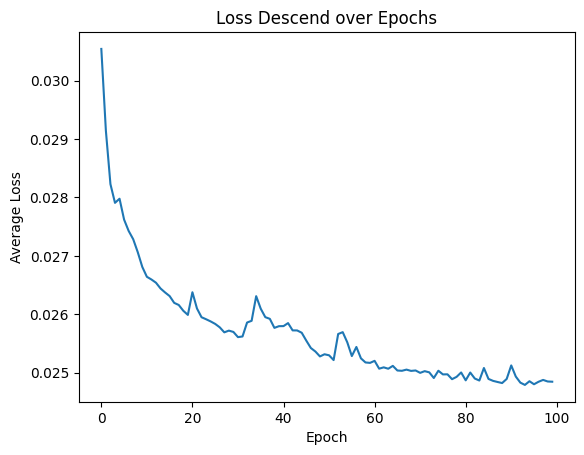

In [14]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss Descend over Epochs')
plt.show()

In [15]:
# save the model
torch.save(model.state_dict(), './trained_models/sequence_model_64.pt')

# Sample one sequence

In [9]:
# load the model
DEVICE = torch.device('cpu')
model = SequenceModel()
model.load_state_dict(torch.load('./trained_models/sequence_model_64.pt', map_location=DEVICE))

<All keys matched successfully>

In [10]:
# sample
model.eval()
batch_size = 1
seq_length = fixed_length

# groud truth sequence
pdb_id, res, atom_coords,  mask = next(iter(test_loader))
atom_coords = atom_coords.to(torch.float32)

n_coords = atom_coords[:, :, 0]
ca_coords = atom_coords[:, :, 1]
c_coords = atom_coords[:, :, 2]

rotations, translations = rigidFrom3Points(n_coords, ca_coords, c_coords)
pair_repr = torch.cdist(ca_coords, ca_coords, p=2).to(DEVICE)

mask = mask.bool()

sequences = tensor_to_string(res, label_res_dict)
print("PDB ID:",pdb_id[0])

# prepare data, only generate one sequence corresponding to ground truth backbone structure
x_t = torch.ones(batch_size, seq_length, device=DEVICE, dtype=torch.int64) * 21

rotation = rotations[0].unsqueeze(0)
translation = translations[0].unsqueeze(0)
rotation = rotation.to(DEVICE)
translation = translation.to(DEVICE)
pair_repr = pair_repr[0].unsqueeze(0)

mask = mask[0].unsqueeze(0).to(DEVICE)

unmasked = torch.zeros_like(x_t, device=DEVICE).bool()
sample_steps = list(range(1, 100+1))

# sample
for t in reversed(sample_steps):
  t = torch.full((batch_size,), t, device=DEVICE, dtype=torch.int64)
  # where to unmask
  t_mask = t.reshape(batch_size, 1)
  t_mask = t_mask.expand(batch_size, seq_length)

  changes = torch.rand_like(x_t.float()) < 1 / t_mask.float()
  changes = torch.bitwise_xor(changes, torch.bitwise_and(changes, unmasked))
  
  # update mask with changes
  unmasked = torch.bitwise_or(unmasked, changes)
  
  x_0_logits = model(x_t.float(), pair_repr, rotation, translation)
  index = torch.argmax(x_0_logits, dim=2)

  x_t.long()[changes] = index.long()[changes]

  x_t = x_t * mask # mask out the padding
  
  sequence = tensor_to_string(x_t, label_res_dict)
  print(print(f"t = {t.item()}:", sequence))

print("ground truth sequence is:", sequences[0])

PDB ID: ('1a0j', 'A')
t = 100: ['************************V***************************************']
None
t = 99: ['************************V***************************************']
None
t = 98: ['************************V***************************************']
None
t = 97: ['************************V***************************************']
None
t = 96: ['************************V***************************************']
None
t = 95: ['************************V****************A**********************']
None
t = 94: ['************************V****************A**********************']
None
t = 93: ['***************A********V***************DA**********************']
None
t = 92: ['***************A********V***************DA**********************']
None
t = 91: ['********E******A********V***************DA**********************']
None
t = 90: ['*E****P*E******A********V***************DA**********************']
None
t = 89: ['*E****P*E******A********V***************DA**********************'

# Sequence recovery rate on test set

In [39]:
model.eval()
sequence_recovery_rate_list = []

for batch_idx, (pdb, res_label, atom_coords, mask) in enumerate(tqdm(test_loader)):
    # Data preparation
    batch_size = res_label.shape[0]
    
    atom_coords = atom_coords.to(torch.float32)
    n_coords = atom_coords[:, :, 0]
    ca_coords = atom_coords[:, :, 1]
    c_coords = atom_coords[:, :, 2]

    rotations, translations = rigidFrom3Points(n_coords, ca_coords, c_coords)
    pair_repr = torch.cdist(ca_coords, ca_coords, p=2).to(DEVICE)

    mask = mask.bool()
    
    x_t = diffusion.p_sample(model, batch_size, DEVICE, pair_repr, rotations.to(DEVICE), translations.to(DEVICE))
    accuracy = sequence_recovery_rate(x_t, res_label, mask)
    accuracy = torch.mean(accuracy)
    sequence_recovery_rate_list.append(accuracy.item())
        

100%|██████████| 35/35 [54:57<00:00, 94.21s/it]


In [41]:
print("the mean of sequence recovery rate:", np.mean(sequence_recovery_rate_list))
print("the std of sequence recovery rate:", np.std(sequence_recovery_rate_list))

the mean of sequence recovery rate: 0.27018554721559795
the std of sequence recovery rate: 0.013461152883705875


In [42]:
total_data.append(sequence_recovery_rate_list)

In [58]:
# save total data in npy file
total_data = np.array(total_data)
np.save('./data/sequence_recovery_rate_testset.npy', total_data)

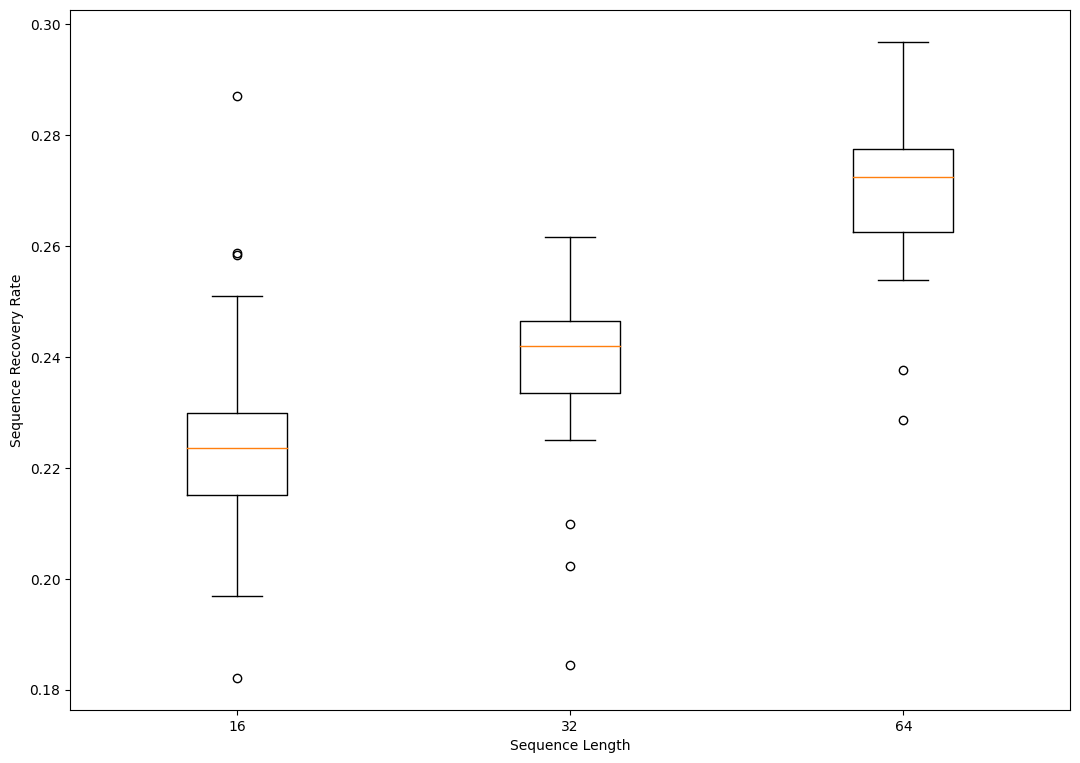

In [60]:
total_data = total_data.tolist()

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
ax.boxplot(total_data)
ax.set_xticklabels(['16', '32', '64'])
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Sequence Recovery Rate')
# show plot
plt.show()

# Sequence recovery rate on 4 test examples with 64 amino acids

In [18]:
test_samples = ["('1acf', 'A')", "('1bkr', 'A')", "('1cc8', 'A')", "('3mx7', 'A')"]
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1)
result_dict = {}

# get above four pdb data
for batch_idx, (pdb, res_label, atom_coords, mask) in enumerate(tqdm(test_loader)):
    pdb = pdb[0]
    if pdb in test_samples:
        print(pdb)
        accuracy_list = []
        for i in range(100):
            batch_size = res_label.shape[0]
            atom_coords = atom_coords.to(torch.float32)
            n_coords = atom_coords[:, :, 0]
            ca_coords = atom_coords[:, :, 1]
            c_coords = atom_coords[:, :, 2]

            rotations, translations = rigidFrom3Points(n_coords, ca_coords, c_coords)
            pair_repr = torch.cdist(ca_coords, ca_coords, p=2).to(DEVICE)

            mask = mask.bool()
            
            x_t = diffusion.p_sample(model, batch_size, DEVICE, pair_repr, rotations.to(DEVICE), translations.to(DEVICE))
            accuracy = sequence_recovery_rate(x_t, res_label, mask)
            accuracy_list.append(accuracy.item())
        result_dict[pdb] = accuracy_list
        
    

  0%|          | 0/4372 [00:00<?, ?it/s]

('1acf', 'A')


  0%|          | 10/4372 [03:52<28:08:27, 23.22s/it]

('1bkr', 'A')


  1%|          | 49/4372 [07:44<10:17:57,  8.58s/it]

('1cc8', 'A')


 57%|█████▋    | 2511/4372 [11:33<03:39,  8.49it/s] 

('3mx7', 'A')


100%|██████████| 4372/4372 [15:25<00:00,  4.72it/s]


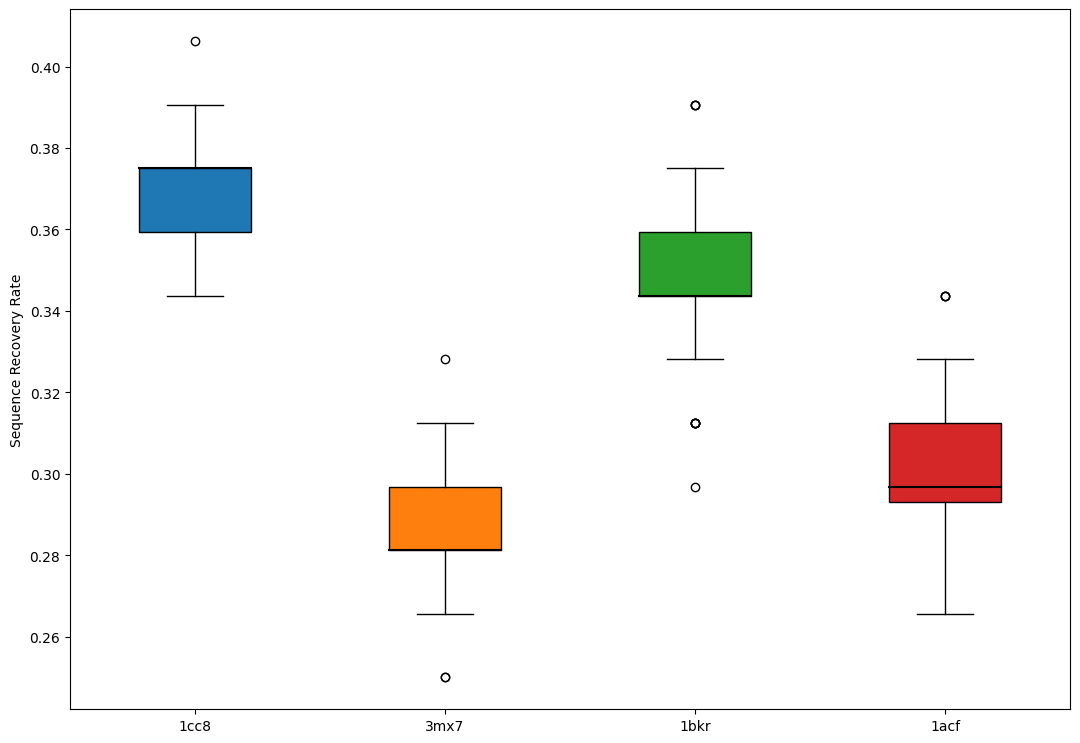

In [33]:
result_data = [result_dict["('1cc8', 'A')"], result_dict["('3mx7', 'A')"], result_dict["('1bkr', 'A')"], result_dict["('1acf', 'A')"]]

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Define colors for the boxes
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Create the boxplots with custom colors
boxplot = ax.boxplot(result_data, patch_artist=True, medianprops=dict(color="black",linewidth=1.5))

for patch, color in (zip(boxplot['boxes'], colors)):
    patch.set_facecolor(color)

# Creating plot
ax.set_xticklabels(['1cc8', '3mx7', '1bkr', '1acf'])
ax.set_ylabel('Sequence Recovery Rate')
# show plot
plt.show()

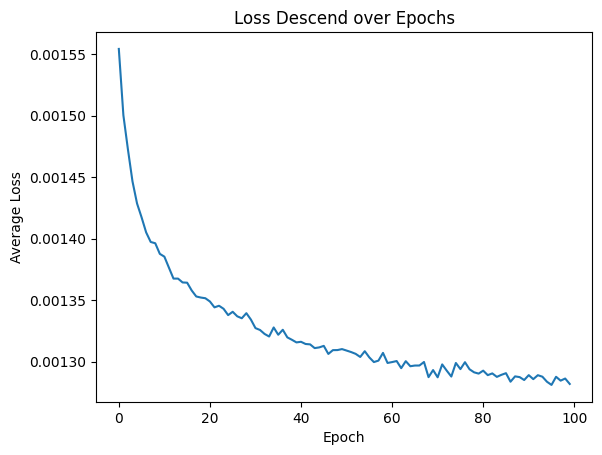

In [8]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss Descend over Epochs')
plt.show()

In [9]:
# save the model
torch.save(model.state_dict(), './trained_models/sequence_model_pairwise.pt')

In [17]:
# sample
model.eval()
batch_size = 1
seq_length = 20

# groud truth sequence
pdb_id, res, atom_coords = next(iter(test_loader))
atom_coords = atom_coords.to(torch.float32)
n_coords = atom_coords[:, :, 0]
ca_coords = atom_coords[:, :, 1]
c_coords = atom_coords[:, :, 2]
rotations, translations = rigidFrom3Points(n_coords, ca_coords, c_coords)
pair_repr = torch.cdist(ca_coords, ca_coords, p=2).to(DEVICE)

res = res.squeeze()
sequences = tensor_to_string(res, label_res_dict)
print("PDB ID:",pdb_id[0])

# prepare data, only generate one sequence corresponding to ground truth backbone structure
x_t = torch.ones(batch_size, seq_length, device=DEVICE, dtype=torch.int64) * 21

rotation = rotations[0].unsqueeze(0)
translation = translations[0].unsqueeze(0)
rotation = rotation.to(DEVICE)
translation = translation.to(DEVICE)
pair_repr = pair_repr[0].unsqueeze(0)

#rotations = repeat(torch.eye(3), 'r1 r2 -> b n r1 r2', b = batch_size, n = seq_length)
#translations  = torch.randn(batch_size, seq_length, 3, device=DEVICE)
unmasked = torch.zeros_like(x_t, device=DEVICE).bool()
sample_steps = list(range(1, 100+1))

# sample
for t in reversed(sample_steps):
  t = torch.full((batch_size,), t, device=DEVICE, dtype=torch.int64)
  # where to unmask
  t_mask = t.reshape(batch_size, 1)
  t_mask = t_mask.expand(batch_size, 20)

  changes = torch.rand_like(x_t.float()) < 1 / t_mask.float()
  changes = torch.bitwise_xor(changes, torch.bitwise_and(changes, unmasked))
  
  # update mask with changes
  unmasked = torch.bitwise_or(unmasked, changes)
  x_0_logits = model(x_t.float(), pair_repr, rotation, translation)
  index = torch.argmax(x_0_logits,dim=2)

  x_t.long()[changes] = index.long()[changes]

  sequence = tensor_to_string(x_t, label_res_dict)
  print(print(f"t = {t.item()}:", sequence))

print("ground truth sequence is:", sequences[0])

PDB ID: 1hxvA
t = 100: ['********************']
None
t = 99: ['********************']
None
t = 98: ['********************']
None
t = 97: ['********************']
None
t = 96: ['*************L******']
None
t = 95: ['*************L******']
None
t = 94: ['********K****L******']
None
t = 93: ['********K****L******']
None
t = 92: ['********K****L******']
None
t = 91: ['********K****L******']
None
t = 90: ['********K****L******']
None
t = 89: ['********K****L******']
None
t = 88: ['********K****L******']
None
t = 87: ['********K****L******']
None
t = 86: ['********K****L******']
None
t = 85: ['********K****L******']
None
t = 84: ['********K****L******']
None
t = 83: ['********K****L******']
None
t = 82: ['********K****L******']
None
t = 81: ['********K****L****S*']
None
t = 80: ['********K****L****S*']
None
t = 79: ['********K****L****S*']
None
t = 78: ['********K****L****S*']
None
t = 77: ['********K****L**N*S*']
None
t = 76: ['********K****L**N*S*']
None
t = 75: ['********K****L**N*S*']
No